In [5]:
import os
from typing import List, Tuple
import cv2
import numpy as np
from tqdm import tqdm
import dlib
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
import matplotlib.cm as cm
from PIL import Image
import random
import shutil

# Global initialization for Dlib and MediaPipe
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"  # Path to Dlib pre-trained model
detector_dlib = dlib.get_frontal_face_detector()
predictor_dlib = dlib.shape_predictor(PREDICTOR_PATH)
mp_face_mesh = mp.solutions.face_mesh
landmarks_68_indices = [
    162, 234, 93, 58, 172, 136, 149, 148, 152, 377, 378, 365, 397, 288, 323, 454, 389, 71, 63, 105, 66,
    107, 336, 296, 334, 293, 301, 168, 197, 5, 4, 75, 97, 2, 326, 305, 33, 160, 158, 133, 153, 144, 362,
    385, 387, 263, 373, 380, 61, 39, 37, 0, 267, 269, 291, 405, 314, 17, 84, 181, 78, 82, 13, 312, 308,
    317, 14, 87
]

def save_labels(output_label_path: str, labels: List[List[float]]) -> None:
    """
    Save labels in the required format: one line per detection, all coordinates on a single line.

    Args:
        output_label_path (str): Path to save the labels.
        labels (List[List[float]]): List of landmark coordinates per detection.
    """
    # Open the specified file in write mode
    with open(output_label_path, 'w') as file:
        # Iterate through each set of labels (one for each detection)
        for label in labels:
            # Write all coordinates as a single line, separated by spaces
            file.write(" ".join(map(str, label)) + "\n")

def plot_keypoints(image: np.ndarray, keypoints: List[Tuple[float, float]], output_path: str, 
                   color: Tuple[int, int, int], min_radius: int = 8, max_radius: int = 16) -> None:
    """
    Plot keypoints on the image and save the result. The size of the keypoints adapts to the image resolution.

    Args:
        image (np.ndarray): Input image.
        keypoints (List[Tuple[float, float]]): List of (x, y) coordinates of keypoints.
        output_path (str): Path to save the plotted image.
        color (Tuple[int, int, int]): Color of the keypoints (B, G, R).
        min_radius (int): Minimum radius for keypoints.
        max_radius (int): Maximum radius for keypoints.
    """
    # Extract image dimensions (height, width, and channels)
    height, width, _ = image.shape
    # Calculate the diagonal length of the image to determine the proportional keypoint size
    image_diagonal = (width**2 + height**2) ** 0.5
    # Calculate radius based on 1% of the diagonal, constrained by min_radius and max_radius
    radius = max(min_radius, min(int(image_diagonal * 0.01), max_radius))
    # Thickness for the circles (-1 means filled circles)
    thickness = -1

    # Iterate over each keypoint (x, y) pair
    for x, y in keypoints:
        # Ensure x and y are integers for OpenCV functions
        x, y = int(x), int(y)
        # Check if the keypoint is within the image boundaries
        if 0 <= x < width and 0 <= y < height:
            # Draw a circle at the keypoint location on the image
            cv2.circle(image, (x, y), radius, color, thickness)

    # Save the image with the plotted keypoints
    cv2.imwrite(output_path, image)

def process_image_with_model(
    image: np.ndarray,
    model: str,
    output_image_path: str,
    output_label_path: str,
    normalize: bool = False
) -> bool:
    """
    Process an image with a specified model (Dlib or MediaPipe) to detect and save landmarks.

    Args:
        image (np.ndarray): Input image.
        model (str): Model to use ('dlib' or 'mediapipe').
        output_image_path (str): Path to save the image with landmarks.
        output_label_path (str): Path to save the landmark labels.
        normalize (bool): Whether to normalize the coordinates.

    Returns:
        bool: True if landmarks were detected, False otherwise.
    """
    # Extract the height and width of the image
    h, w = image.shape[:2]
    # Initialize empty lists for labels and keypoints
    labels = []
    keypoints = []

    if model == "dlib":
        # Convert the image to grayscale (Dlib works with grayscale images)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect faces in the image
        faces = detector_dlib(gray, 1)

        # Iterate over each detected face
        for face in faces:
            # Predict 68 facial landmarks for the detected face
            landmarks = predictor_dlib(gray, face)
            coords = []  # Temporary list to store coordinates for the current face
            # Extract each landmark (x, y) and optionally normalize
            for i in range(68):
                x = landmarks.part(i).x
                y = landmarks.part(i).y
                if normalize:
                    x, y = x / w, y / h  # Normalize based on image dimensions
                coords.extend([x, y])  # Add coordinates as [x, y]
                keypoints.append((x, y))  # Store for plotting
            labels.append(coords)  # Add all coordinates for the current face to labels

        # Set the color for plotting (blue for Dlib)
        color = (255, 0, 0)

    elif model == "mediapipe":
        # Convert the image to RGB (MediaPipe expects RGB format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Initialize MediaPipe's FaceMesh model
        with mp_face_mesh.FaceMesh(
            static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5
        ) as face_mesh:
            # Process the image to detect landmarks
            results = face_mesh.process(image_rgb)
            # If any landmarks are detected, iterate over them
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    coords = []  # Temporary list for the current face
                    # Extract and optionally normalize the 68 specified landmarks
                    for idx in landmarks_68_indices:
                        landmark = face_landmarks.landmark[idx]
                        x, y = (landmark.x, landmark.y) if normalize else (int(landmark.x * w), int(landmark.y * h))
                        coords.extend([x, y])
                        keypoints.append((x, y))  # Store for plotting
                    labels.append(coords)

        # Set the color for plotting (green for MediaPipe)
        color = (0, 255, 0)

    else:
        # Raise an error if an unsupported model is specified
        raise ValueError("Invalid model specified. Choose 'dlib' or 'mediapipe'.")

    # If landmarks were detected, save the results
    if labels:
        # Plot keypoints on the image and save it
        plot_keypoints(image.copy(), keypoints, output_image_path, color)
        # Save the landmark coordinates to a file
        save_labels(output_label_path, labels)
        return True  # Return True indicating successful detection

    return False  # Return False if no landmarks were detected

def process_images_in_directory(
    input_dir: str,
    dlib_output_dir: str,
    mediapipe_output_dir: str,
    normalize: bool = False
) -> None:
    """
    Process all images in a directory using Dlib and MediaPipe models.

    Args:
        input_dir (str): Directory containing input images.
        dlib_output_dir (str): Directory to save Dlib outputs.
        mediapipe_output_dir (str): Directory to save MediaPipe outputs.
        normalize (bool): Whether to normalize the coordinates.
    """
    # Create subdirectories for images and labels for both models
    os.makedirs(os.path.join(dlib_output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dlib_output_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(mediapipe_output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(mediapipe_output_dir, 'labels'), exist_ok=True)

    # Get a list of image files from the input directory
    images = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))]

    # Dictionary to store detection results for both models
    results = {"dlib": {"detected": 0, "not_detected": []}, "mediapipe": {"detected": 0, "not_detected": []}}

    # Process each model (Dlib and MediaPipe)
    for model, output_dir in [("dlib", dlib_output_dir), ("mediapipe", mediapipe_output_dir)]:
        print(f"\nProcessing with {model.capitalize()}...")
        # Iterate over all images
        for filename in tqdm(images, desc=f"{model.capitalize()} Progress"):
            # Construct the full image path
            image_path = os.path.join(input_dir, filename)
            # Read the image from disk
            image = cv2.imread(image_path)
            # Process the image with the specified model
            detected = process_image_with_model(
                image.copy(),
                model,
                output_image_path=os.path.join(output_dir, 'images', filename),
                output_label_path=os.path.join(output_dir, 'labels', f"{os.path.splitext(filename)[0]}.txt"),
                normalize=normalize
            )
            # Update detection results
            if detected:
                results[model]["detected"] += 1
            else:
                results[model]["not_detected"].append(filename)

    # Print a summary of detections for both models
    for model, res in results.items():
        print(f"\n=== {model.capitalize()} Detection Summary ===")
        print(f"Detected: {res['detected']} images.")
        if res["not_detected"]:
            print(f"Not detected: {len(res['not_detected'])} images:")
            print("\n".join(res["not_detected"]))



In [4]:
input_directory = "/Users/jocareher/Downloads/baby_face_72_test/images"
dlib_predictions_dir = "dlib_predictions_test"
mediapipe_predictions_dir = "mediapipe_68_lmks_predictions_test"

process_images_in_directory(input_directory, dlib_predictions_dir, mediapipe_predictions_dir, normalize=False)



Processing with Dlib...


Dlib Progress: 100%|██████████| 21/21 [01:33<00:00,  4.47s/it]



Processing with Mediapipe...


Mediapipe Progress:   0%|          | 0/21 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1737563328.053306 2847833 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737563328.063663 2855226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737563328.073128 2855225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Mediapipe Progress:   5%|▍         | 1/21 [00:00<00:03,  5.37it/s]I0000 00:00:1737563328.179775 2847833 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Max
W0000 00:00:1737563328.181300 2855241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature infere


=== Dlib Detection Summary ===
Detected: 4 images.
Not detected: 17 images:
face_bcn_20.JPG
face_bcn_08.JPG
face_bcn_09.JPG
face_bcn_16.JPG
face_bcn_17.JPG
face_bcn_01.JPG
face_bcn_15.JPG
face_bcn_14.JPG
face_bcn_00.JPG
face_bcn_04.JPG
face_bcn_10.JPG
face_bcn_11.JPG
face_bcn_05.JPG
face_bcn_13.JPG
face_bcn_07.JPG
face_bcn_06.JPG
face_bcn_12.JPG

=== Mediapipe Detection Summary ===
Detected: 10 images.
Not detected: 11 images:
face_bcn_20.JPG
face_bcn_08.JPG
face_bcn_09.JPG
face_bcn_17.JPG
face_bcn_01.JPG
face_bcn_15.JPG
face_bcn_14.JPG
face_bcn_00.JPG
face_bcn_04.JPG
face_bcn_10.JPG
face_bcn_11.JPG


In [ ]:
def create_video_from_images(images: List[str], output_path: str, frame_rate: int = 30) -> None:
    """
    Creates a video from a list of image paths and overlays the image filename as a title on each frame.

    Args:
        images (List[str]): List of image file paths to include in the video.
        output_path (str): The output path for the generated video file.
        frame_rate (int): The frame rate (frames per second) of the video.
    """
    if not images:
        print("No images provided for video generation.")
        return

    # Read the first image to get the frame size
    first_image = cv2.imread(images[0])
    if first_image is None:
        print(f"Error: Unable to read {images[0]}")
        return
    height, width, _ = first_image.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    # Loop through all images and write each one to the video
    for idx, image_path in enumerate(images):
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Warning: Unable to read {image_path}, skipping.")
            continue

        # Confirm that frame size matches the first image (for consistency in the video)
        if frame.shape[0] != height or frame.shape[1] != width:
            print(f"Warning: Image {image_path} has a different size, resizing.")
            frame = cv2.resize(frame, (width, height))
        
        # Get the base filename (without path) to display on the frame
        image_name = os.path.basename(image_path)
        
        # Set font properties
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 0)  # White color
        font_thickness = 2
        text_position = (50, 50)  # Position to display the filename (x, y)

        # Add the filename text to the frame
        cv2.putText(frame, image_name, text_position, font, font_scale, font_color, font_thickness, cv2.LINE_AA)
        
        # Write the current frame to the video
        video_writer.write(frame)
        print(f"Added frame {idx + 1}/{len(images)}: {image_path}")

    # Release the video writer once the video is completed
    video_writer.release()
    print(f"Video saved at {output_path}")

def collect_images_by_orientation(root_dir: str) -> dict:
    """
    Collects images from all subdirectories in the root directory and categorizes them by orientation.

    Args:
        root_dir (str): The root directory containing subdirectories with images.

    Returns:
        dict: A dictionary where the keys are orientations ('frontal', 'left', etc.) and
              the values are lists of image paths.
    """
    orientation_dict = {
        'frontal': [],
        'left': [],
        'right': [],
        'quarter_left': [],
        'quarter_right': []
    }

    # Traverse the root directory and all subdirectories
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpg') and 'with_landmarks' not in file:
                # Determine orientation based on the filename
                if 'frontal' in file:
                    orientation_dict['frontal'].append(os.path.join(subdir, file))
                elif 'left' in file and 'quarter' not in file:
                    orientation_dict['left'].append(os.path.join(subdir, file))
                elif 'right' in file and 'quarter' not in file:
                    orientation_dict['right'].append(os.path.join(subdir, file))
                elif 'quarter_left' in file:
                    orientation_dict['quarter_left'].append(os.path.join(subdir, file))
                elif 'quarter_right' in file:
                    orientation_dict['quarter_right'].append(os.path.join(subdir, file))

    # Sort images by name to ensure they are in correct sequence
    for orientation, image_list in orientation_dict.items():
        orientation_dict[orientation] = sorted(image_list)

    return orientation_dict

def create_videos_for_all_orientations(root_dir: str, output_dir: str, frame_rate: int = 30) -> None:
    """
    Creates videos for each orientation from the images in all subdirectories of the root directory.

    Args:
        root_dir (str): The root directory containing subdirectories with images.
        output_dir (str): The output directory where the videos will be saved.
        frame_rate (int): The frame rate (frames per second) of the video.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Collect all images categorized by orientation from all subdirectories
    images_by_orientation = collect_images_by_orientation(root_dir)

    # Create a video for each orientation
    for orientation, images in images_by_orientation.items():
        print(images)
        if images:
            output_path = os.path.join(output_dir, f"{orientation}.mp4")
            create_video_from_images(images, output_path, frame_rate)
        else:
            print(f"No images found for {orientation} orientation.")

In [ ]:
def convert_pts_to_yolo_format(pts_file_path: str, image_file_path: str, output_txt_path: str, normalize: bool = True, has_visibility: bool = False, modify_visibility: bool = False) -> None:
    """
    Converts a .pts file containing landmarks to a YOLOv8 format (x1 y1 visibility ... xn yn visibility),
    with an option to normalize the coordinates based on the image dimensions and optionally modify visibility values.

    Args:
        pts_file_path (str): The path to the .pts file to be converted.
        image_file_path (str): The path to the corresponding image file to get dimensions for normalization.
        output_txt_path (str): The path to save the converted .txt file in YOLOv8 format.
        normalize (bool): Whether to normalize the coordinates based on image size. Defaults to True.
        has_visibility (bool): Whether the .pts file includes visibility information (0 or 1). Defaults to False.
        modify_visibility (bool): If True, converts visibility values from 0 to 1 and 1 to 2. Defaults to False.
    """
    # Read image dimensions
    image = cv2.imread(image_file_path)
    if image is None:
        print(f"Error: Could not read the image {image_file_path}")
        return
    height, width = image.shape[:2]

    with open(pts_file_path, 'r') as pts_file:
        lines = pts_file.readlines()

    # We will skip the first two lines and extract only the coordinates
    coordinates = []
    for line in lines[2:]:  # Skip "Version" and number of points
        parts = line.split()
        if len(parts) >= 3:
            # Extract x, y coordinates (skip the label 'SXXXX')
            x, y = float(parts[1]), float(parts[2])

            # Normalize coordinates if the flag is set to True
            if normalize:
                x /= width
                y /= height

            # Handle visibility if has_visibility is True
            if has_visibility and len(parts) > 3:
                visibility = int(parts[3])
                if modify_visibility:
                    visibility = 1 if visibility == 0 else 2  # Modify visibility as requested
                coordinates.append(f"{x} {y} {visibility}")
            else:
                coordinates.append(f"{x} {y}")

    # Write the coordinates in YOLOv8 format (single line)
    with open(output_txt_path, 'w') as txt_file:
        txt_file.write(' '.join(coordinates) + '\n')

    print(f"Converted {pts_file_path} to YOLOv8 format at {output_txt_path}")


def process_pts_directory_for_yolo(root_directory: str, output_directory: str, normalize: bool = True, has_visibility: bool = False, modify_visibility: bool = False) -> None:
    """
    Processes all .pts files in the root directory and its subdirectories, converts them to YOLOv8 format,
    normalizing the coordinates based on image dimensions if specified, and saves the output
    in the corresponding subdirectory in the output directory.

    Args:
        root_directory (str): The root directory containing subdirectories with .pts files and images.
        output_directory (str): The root directory where the converted .txt files will be saved in YOLOv8 format.
        normalize (bool): Whether to normalize the coordinates based on image size. Defaults to True.
        has_visibility (bool): Whether the .pts files include visibility information (0 or 1). Defaults to False.
        modify_visibility (bool): If True, modifies visibility values (0->1 and 1->2). Defaults to False.
    """
    # Traverse all subdirectories in the root directory
    for subdir, _, files in os.walk(root_directory):
        # Create a corresponding subdirectory in the output directory
        relative_path = os.path.relpath(subdir, root_directory)
        output_subdir = os.path.join(output_directory, relative_path)
        os.makedirs(output_subdir, exist_ok=True)

        for filename in files:
            if filename.endswith('.pts'):
                # Get corresponding image file with the same base name
                base_name = filename.replace('.pts', '')
                image_file_path = os.path.join(subdir, base_name + '.jpg')
                
                # Check if the corresponding image file exists
                if not os.path.exists(image_file_path):
                    print(f"Warning: Image {image_file_path} not found for {filename}, skipping.")
                    continue

                pts_file_path = os.path.join(subdir, filename)
                output_txt_path = os.path.join(output_subdir, filename.replace('.pts', '.txt'))

                # Convert .pts to YOLOv8 format, normalizing coordinates based on the image size
                convert_pts_to_yolo_format(pts_file_path, image_file_path, output_txt_path, normalize, has_visibility, modify_visibility)

                print(f"Processed {filename}: saved as {output_txt_path}")


In [ ]:
# FIRST STEP
root_dir = "/Users/jocareher/Documents/synthetic_images_train"
output_dir = "/Users/jocareher/Documents/pts_to_txt_vis_12"
process_pts_directory_for_yolo(root_directory=root_dir,
                               output_directory=output_dir,
                               has_visibility=True,
                               modify_visibility=True)

Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_frontal.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_frontal.txt
Processed synthetic_shape_01711_frontal.pts: saved as /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_frontal.txt
Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_right.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_right.txt
Processed synthetic_shape_01711_right.pts: saved as /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_01711_right.txt
Converted /Users/jocareher/Documents/synthetic_images_train/synthetic_shape_01711/synthetic_shape_01711_quarter_left.pts to YOLOv8 format at /Users/jocareher/Documents/pts_to_txt_vis_12/synthetic_shape_01711/synthetic_shape_

In [ ]:
def plot_landmarks_on_image(image_path: str, txt_path: str, normalized: bool = True) -> None:
    """
    Plots landmarks from a YOLOv8-formatted .txt file onto an image and displays the result using matplotlib.

    Args:
        image_path (str): The path to the image file.
        txt_path (str): The path to the .txt file containing landmarks in YOLOv8 format.
        normalized (bool): Whether the coordinates in the .txt file are normalized (in the range [0, 1]).
                           Defaults to True.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read the image {image_path}")
        return
    # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    height, width = image.shape[:2]

    # Read the coordinates from the .txt file
    with open(txt_path, 'r') as f:
        line = f.readline().strip()
        coordinates = list(map(float, line.split()))

    # Ensure that we have an even number of coordinates (x, y pairs)
    if len(coordinates) % 2 != 0:
        print(f"Error: Mismatched number of coordinates in {txt_path}")
        return

    # Plot each landmark point on the image
    for i in range(0, len(coordinates), 2):
        x, y = coordinates[i], coordinates[i + 1]

        # If the coordinates are normalized, denormalize them
        if normalized:
            x = int(x * width)
            y = int(y * height)

        # Draw the point on the image (green dot)
        cv2.circle(image_rgb, (int(x), int(y)), 3, (0, 255, 0), 2)

    # Display the image with landmarks using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [ ]:
def contains_nan(txt_file_path: str) -> bool:
    """
    Checks if the given .txt file contains any NaN values in the coordinates.

    Args:
        txt_file_path (str): Path to the .txt file containing coordinates.

    Returns:
        bool: True if the file contains NaN values, False otherwise.
    """
    with open(txt_file_path, 'r') as f:
        line = f.readline().strip()
        coordinates = line.split()

    # Convert all values to float and check if any are NaN
    coordinates = [float(value) for value in coordinates]
    return any(np.isnan(coordinates))


def organize_images_and_labels(image_root: str, label_root: str, output_root: str) -> None:
    """
    Organizes images and labels by copying all valid pairs (no NaN in labels) to a single directory with 'images' and 'labels' subdirectories.
    Images and labels with NaN values are left in their original locations.

    Args:
        image_root (str): The root directory containing subdirectories with images.
        label_root (str): The root directory containing subdirectories with .txt label files.
        output_root (str): The root directory where 'images' and 'labels' subdirectories will be created for valid files.
    """
    # Create output directories for images and labels if they don't exist
    output_image_dir = os.path.join(output_root, "images")
    output_label_dir = os.path.join(output_root, "labels")
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for subdir, _, files in os.walk(label_root):
        for label_file in files:
            if label_file.endswith('.txt'):
                # Determine corresponding image path based on the label file
                label_file_path = os.path.join(subdir, label_file)
                image_file_name = label_file.replace('.txt', '.jpg')
                
                # Build image file path by mapping the label directory structure to the image_root
                relative_subdir = os.path.relpath(subdir, label_root)
                image_file_path = os.path.join(image_root, relative_subdir, image_file_name)
                
                # Check if both the image and label file exist
                if os.path.exists(image_file_path) and os.path.exists(label_file_path):
                    if contains_nan(label_file_path):
                        print(f"NaN found in {label_file}, leaving in original location.")
                        # Leave the image and label in the original location
                    else:
                        # Move the valid image and label to the respective directories under output_root
                        shutil.copy(image_file_path, os.path.join(output_image_dir, image_file_name))
                        shutil.copy(label_file_path, os.path.join(output_label_dir, label_file))
                        print(f"Copied {image_file_name} and {label_file} to {output_image_dir} and {output_label_dir}.")


In [ ]:
# SECOND STEP
image_root = "/Users/jocareher/Documents/synthetic_images_train"
label_root = "/Users/jocareher/Documents/pts_to_txt_vis_12"
dataset_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12"
organize_images_and_labels(image_root,
                           label_root,
                           dataset_dir)

Copied synthetic_shape_01711_right.jpg and synthetic_shape_01711_right.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_frontal.jpg and synthetic_shape_01711_frontal.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_quarter_left.jpg and synthetic_shape_01711_quarter_left.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_quarter_right.jpg and synthetic_shape_01711_quarter_right.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_01711_left.jpg and synthetic_shape_01711_left.txt to /Users/jocareher/Downloads/lmks_labels_vis_12/images and /Users/jocareher/Downloads/lmks_labels_vis_12/labels.
Copied synthetic_shape_

In [ ]:
def get_class_index(filename: str) -> int:
    """
    Returns the class index based on the filename.

    Args:
        filename (str): The name of the file (without directory path).

    Returns:
        int: The corresponding class index.
    """
    if 'quarter_left' in filename:
        return 0
    elif 'quarter_right' in filename:
        return 1
    elif 'frontal' in filename:
        return 2
    elif 'left' in filename:
        return 3
    elif 'right' in filename:
        return 4
    else:
        raise ValueError(f"Filename '{filename}' does not match any expected orientation.")


def add_class_index_to_landmarks_labels(txt_dir: str, include_bbox: bool = True) -> None:
    """
    Reads all .txt files in the directory and adds a class index to each file based on its filename.
    Optionally, also adds 0 0 0 0 to the bounding box fields.

    Args:
        txt_dir (str): The directory containing the .txt files.
        include_bbox (bool): Whether to add 0 0 0 0 as the bounding box values. Defaults to True.
    """
    # Process each .txt file in the directory
    for txt_file in os.listdir(txt_dir):
        if txt_file.endswith('.txt'):
            txt_file_path = os.path.join(txt_dir, txt_file)

            # Get the class index based on the filename
            class_index = get_class_index(txt_file)

            # Read the existing coordinates from the file
            with open(txt_file_path, 'r') as f:
                coordinates = f.readline().strip()

            # If include_bbox is True, prepend the class index and "0 0 0 0" for the bounding box
            if include_bbox:
                updated_content = f"{class_index} 0 0 0 0 {coordinates}"
            else:
                # Only prepend the class index without bounding box values
                updated_content = f"{class_index} {coordinates}"

            # Write the updated content back to the file
            with open(txt_file_path, 'w') as f:
                f.write(updated_content)
            
            print(f"Updated {txt_file} with class index {class_index} and bounding box {include_bbox}.")

In [ ]:
# THIRD STEP
txt_dir = "/Users/jocareher/Downloads/lmks_labels_vis_12/labels"
add_class_index_to_landmarks_labels(txt_dir,
                                    False)

Updated synthetic_shape_00264_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_01840_quarter_left.txt with class index 0 and bounding box False.
Updated synthetic_shape_00787_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_00507_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_01185_left.txt with class index 3 and bounding box False.
Updated synthetic_shape_01315_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_00057_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_01645_frontal.txt with class index 2 and bounding box False.
Updated synthetic_shape_00855_quarter_right.txt with class index 1 and bounding box False.
Updated synthetic_shape_00028_quarter_right.txt with class index 1 and bounding box False.
Updated synthetic_shape_00052_right.txt with class index 4 and bounding box False.
Updated synthetic_shape_00578_right.txt with class index 

In [ ]:
def count_landmark_visibility_by_orientation(root_dir):
    """
    Counts the number of visible and occluded landmarks in the dataset,
    grouped by orientation (class index) and partition (train, val, test).
    
    Args:
        root_dir (str): Path to the root directory containing "train", "val", and "test" subdirectories,
                        each with "labels" subdirectory.
    """
    # Definir las particiones y las clases
    partitions = ['train', 'val', 'test']
    orientations = {
        0: "quarter_left",
        1: "quarter_right",
        2: "frontal",
        3: "left",
        4: "right"
    }
    
    # Diccionario para almacenar los conteos
    visibility_counts = {
        partition: {orientation: {"visible": 0, "occluded": 0} for orientation in orientations.values()}
        for partition in partitions
    }
    
    # Recorrer cada partición y contar la visibilidad
    for partition in partitions:
        labels_dir = os.path.join(root_dir, partition, 'labels')
        if not os.path.exists(labels_dir):
            print(f"Warning: {labels_dir} not found, skipping.")
            continue

        # Procesar cada archivo .txt en la carpeta de labels
        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(labels_dir, label_file)
                with open(label_path, 'r') as file:
                    lines = file.readlines()

                    # Leer la primera línea para obtener la clase (orientación)
                    if not lines:
                        continue  # Saltar archivos vacíos
                    first_line = lines[0].strip().split()
                    class_idx = int(first_line[0])
                    orientation = orientations.get(class_idx, "Unknown")

                    # Contar los flags de visibilidad
                    for line in lines:
                        parts = line.strip().split()[5:]  # Omitir class_idx y bbox (cx, cy, w, h)
                        for i in range(2, len(parts), 3):  # Leer cada flag de visibilidad
                            visibility_flag = int(parts[i])
                            if visibility_flag == 1:
                                visibility_counts[partition][orientation]["occluded"] += 1
                            elif visibility_flag == 2:
                                visibility_counts[partition][orientation]["visible"] += 1
    
    # Mostrar el resultado
    for partition, counts in visibility_counts.items():
        print(f"\n{partition.capitalize()} set landmarks visibility distribution")
        print("----------")
        for orientation, count in counts.items():
            print(f"{orientation}:")
            print(f"visible = {count['visible']}")
            print(f"occluded = {count['occluded']}")
            print(f"total lmks = {count['occluded'] + count['visible']}")
            print(f"----------")

root_directory = "/Users/jocareher/Downloads/synthetic_lmks_vis_dataset"
count_landmark_visibility_by_orientation(root_directory)


Train set landmarks visibility distribution
----------
quarter_left:
visible = 96037
occluded = 19019
total lmks = 115056
----------
quarter_right:
visible = 95921
occluded = 19135
total lmks = 115056
----------
frontal:
visible = 97487
occluded = 17713
total lmks = 115200
----------
left:
visible = 66563
occluded = 48349
total lmks = 114912
----------
right:
visible = 64751
occluded = 49153
total lmks = 113904
----------

Val set landmarks visibility distribution
----------
quarter_left:
visible = 11982
occluded = 2346
total lmks = 14328
----------
quarter_right:
visible = 11927
occluded = 2401
total lmks = 14328
----------
frontal:
visible = 12218
occluded = 2182
total lmks = 14400
----------
left:
visible = 8266
occluded = 6062
total lmks = 14328
----------
right:
visible = 8061
occluded = 6123
total lmks = 14184
----------

Test set landmarks visibility distribution
----------
quarter_left:
visible = 12081
occluded = 2391
total lmks = 14472
----------
quarter_right:
visible = 1212

In [4]:
def prepare_lmks_test_set(root_dir, csv_path, output_dir):
    """
    Prepares the test set with landmarks in a single line format per face without visibility flag.
    
    Parameters:
    - root_dir (str): Root directory containing the image folders.
    - csv_path (str): Path to the CSV file containing the labels.
    - output_dir (str): Directory where the test set will be created.
    
    Returns:
    None
    """
    # Create necessary output directories
    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Filter the test set: Include only images from google and youtube subsets
    test_set = df[df['image-set'].isin(['google', 'youtube'])]
    
    for _, row in test_set.iterrows():
        # Locate the image file
        image_path = os.path.join(root_dir, 'images', row['image-set'], row['filename'])
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        
        # Copy the image to the output directory
        shutil.copy(image_path, os.path.join(images_dir, row['filename']))
        
        # Extract landmarks as a single line
        landmarks = []
        for i in range(68):  # 68 landmarks
            x = row[f'gt-x{i}']
            y = row[f'gt-y{i}']
            if not pd.isna(x) and not pd.isna(y):  # Check for valid coordinates
                landmarks.extend([x, y])
        
        # Save landmarks in single line format to a .txt file
        label_filename = f"{os.path.splitext(row['filename'])[0]}.txt"
        label_path = os.path.join(labels_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write(" ".join(map(str, landmarks)) + "\n")
        
        # Generate and save plot with landmarks
        generate_landmark_plots(image_path, landmarks, os.path.join(plots_dir, row['filename']))

def generate_landmark_plots(image_path, landmarks, output_path, min_radius=1, max_radius=5, color=(0, 0, 255)):
    """
    Generates a plot of the landmarks overlaid on the original image with dynamic landmark size.
    
    Parameters:
    - image_path (str): Path to the image file.
    - landmarks (list): List of (x, y) tuples representing the landmark coordinates.
    - output_path (str): Path to save the plotted image.
    - min_radius (int): Minimum radius for the landmarks.
    - max_radius (int): Maximum radius for the landmarks.
    - color (tuple): Color of the landmarks (B, G, R).
    
    Returns:
    None
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image: {image_path}")
        return
    
    # Calculate the diagonal of the image to determine proportional landmark size
    height, width, _ = image.shape
    image_diagonal = (width**2 + height**2) ** 0.5

    # Calculate dynamic radius for the landmarks
    radius = max(int(image_diagonal * 0.0025), min_radius)  # Ensure a minimum size
    radius = min(radius, max_radius)  # Cap at maximum size
    thickness = -1  # Fill the circles

    # Draw landmarks on the image
    for i in range(0, len(landmarks), 2):  # Iterate over landmarks (x, y)
        x, y = landmarks[i], landmarks[i + 1]
        cv2.circle(image, (int(x), int(y)), radius, color, thickness)
    
    # Save the image with landmarks
    cv2.imwrite(output_path, image)


prepare_lmks_test_set(
    root_dir='/Users/jocareher/Downloads/infanface-public/',  # Replace with the actual root directory
    csv_path='/Users/jocareher/Downloads/infanface-public/labels.csv',
    output_dir='/Users/jocareher/Downloads/lmks_test_set'
)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [57]:
def load_landmarks_from_txt(file_path):
    """
    Reads landmarks from a .txt file and ensures they are loaded as floats,
    handling missing annotations represented as nan nan, and truncates to 68 points.

    Args:
        file_path (str): Path to the .txt file.

    Returns:
        np.ndarray: Array of shape (N, 68, 2), where N is the number of faces (lines in the file).
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        return None  # File is empty or does not exist

    with open(file_path, 'r') as f:
        lines = f.readlines()

    landmarks = []
    for line in lines:
        # Convert to float, handling nan values
        coords = list(map(float, line.strip().split()))
        
        # Ensure each pair is valid (e.g., not nan)
        valid_landmarks = [
            (coords[i], coords[i + 1]) if not (np.isnan(coords[i]) or np.isnan(coords[i + 1])) else (np.nan, np.nan)
            for i in range(0, len(coords), 2)
        ]
        
        # Truncate to 68 landmarks if more are present
        valid_landmarks = valid_landmarks[:68]
        
        # Append to landmarks
        landmarks.append(np.array(valid_landmarks))

    if len(landmarks) == 0:
        return None

    return np.array(landmarks)



def calculate_iod(landmarks):
    """
    Calculates the interocular distance (iod) using the outer eye corners,
    ignoring nan values.

    Args:
        landmarks (np.ndarray): Array of shape (68, 2) representing the landmarks.

    Returns:
        float: Interocular distance or nan if coordinates are invalid.
    """
    left_eye = landmarks[45]  # Outer corner of left eye
    right_eye = landmarks[36]  # Outer corner of right eye
    if np.isnan(left_eye).any() or np.isnan(right_eye).any():
        return np.nan
    return np.linalg.norm(right_eye - left_eye)

def calculate_box(landmarks):
    """
    Calculates the normalization factor using the bounding box size,
    ignoring nan values.

    Args:
        landmarks (np.ndarray): Array of shape (68, 2) representing the landmarks.

    Returns:
        float: Bounding box size or nan if landmarks are invalid.
    """
    valid_landmarks = landmarks[~np.isnan(landmarks).any(axis=1)]
    if len(valid_landmarks) == 0:
        return np.nan
    x_min, y_min = np.min(valid_landmarks, axis=0)
    x_max, y_max = np.max(valid_landmarks, axis=0)
    width = x_max - x_min
    height = y_max - y_min
    return np.sqrt(width * height)


def calculate_nme_per_face(pred_landmarks, gt_landmarks, normalization_factor):
    """
    Calculates the NME for a single face, ignoring landmarks with nan and handling size mismatches.

    Args:
        pred_landmarks (np.ndarray): Predicted landmarks of shape (68, 2).
        gt_landmarks (np.ndarray): Ground truth landmarks of shape (68, 2).
        normalization_factor (float): Normalization factor (IOD or BOX).

    Returns:
        float: NME value or nan if no valid landmarks exist.
    """
    # Ensure both arrays have the same shape
    assert len(pred_landmarks) == 68 and len(gt_landmarks) == 68, "Mismatch in number of landmarks."

    valid_indices = ~np.isnan(gt_landmarks).any(axis=1) & ~np.isnan(pred_landmarks).any(axis=1)
    if not valid_indices.any():
        return np.nan
    distances = np.linalg.norm(pred_landmarks[valid_indices] - gt_landmarks[valid_indices], axis=1)
    return np.mean(distances) / normalization_factor



def calculate_nme_for_directory(pred_dir, gt_dir):
    """
    Calculates NME for all images in the directories of predictions and ground truth,
    handling missing landmarks and truncating ground truth to 68 points.

    Args:
        pred_dir (str): Directory containing prediction .txt files.
        gt_dir (str): Directory containing ground truth .txt files.

    Returns:
        dict: NME values (IOD and BOX) per image, skipped files, and average NME for both normalizations.
    """
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch in the number of prediction and ground truth files."

    nme_iod_values = []
    nme_box_values = []
    skipped_files = []

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        pred_landmarks = load_landmarks_from_txt(pred_path)
        gt_landmarks = load_landmarks_from_txt(gt_path)

        if pred_landmarks is None or gt_landmarks is None:
            skipped_files.append(pred_file)
            continue

        if len(pred_landmarks[0]) != len(gt_landmarks[0]) or len(pred_landmarks[0]) != 68:
            skipped_files.append(pred_file)
            continue

        for pred_face, gt_face in zip(pred_landmarks, gt_landmarks):
            iod = calculate_iod(gt_face)
            box = calculate_box(gt_face)
            if iod > 0 and box > 0:
                nme_iod = calculate_nme_per_face(pred_face, gt_face, iod)
                nme_box = calculate_nme_per_face(pred_face, gt_face, box)
                if not np.isnan(nme_iod):
                    nme_iod_values.append(nme_iod)
                if not np.isnan(nme_box):
                    nme_box_values.append(nme_box)

    return {
        "nme_iod_values": nme_iod_values,
        "nme_box_values": nme_box_values,
        "average_nme_iod": np.nanmean(nme_iod_values) if nme_iod_values else None,
        "average_nme_box": np.nanmean(nme_box_values) if nme_box_values else None,
        "skipped_files": skipped_files
    }


def evaluate_model_performance(pred_dir, gt_dir):
    """
    Evaluates the performance of a model by calculating NME (IOD and BOX) and handling missing predictions.

    Args:
        pred_dir (str): Directory containing prediction .txt files.
        gt_dir (str): Directory containing ground truth .txt files.

    Returns:
        dict: Evaluation metrics including NME (IOD and BOX), skipped files, and detection rate.
    """
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch in the number of prediction and ground truth files."

    nme_iod_values = []
    nme_box_values = []
    skipped_files = []
    valid_detections = 0
    total_files = len(gt_files)

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        # Load landmarks as floats
        pred_landmarks = load_landmarks_from_txt(pred_path)
        gt_landmarks = load_landmarks_from_txt(gt_path)

        if pred_landmarks is None or gt_landmarks is None:
            skipped_files.append(pred_file)
            continue

        if len(pred_landmarks) != len(gt_landmarks):
            print(f"Error: Landmark mismatch in {pred_file}.")
            skipped_files.append(pred_file)
            continue

        for pred_face, gt_face in zip(pred_landmarks, gt_landmarks):
            iod = calculate_iod(gt_face)
            box = calculate_box(gt_face)
            if iod > 0 and box > 0:
                nme_iod = calculate_nme_per_face(pred_face, gt_face, iod)
                nme_box = calculate_nme_per_face(pred_face, gt_face, box)
                nme_iod_values.append(nme_iod)
                nme_box_values.append(nme_box)
                valid_detections += 1

    skipped_count = len(skipped_files)
    detection_rate = valid_detections / total_files * 100  # Percentage of valid detections

    return {
        "average_nme_iod": np.mean(nme_iod_values) if nme_iod_values else None,
        "average_nme_box": np.mean(nme_box_values) if nme_box_values else None,
        "detection_rate": detection_rate,
        "skipped_files": skipped_files,
        "total_files": total_files,
        "valid_detections": valid_detections,
        "skipped_count": skipped_count
    }



def plot_nme_boxplots(pred_dir, gt_dir, landmark_names):
    """
    Generates a boxplot of NME for each landmark with improved visualization,
    now assuming predictions already have 68 landmarks and groundtruths are truncated to 68.
    
    Args:
        pred_dir (str): Directory containing prediction .txt files.
        gt_dir (str): Directory containing ground truth .txt files.
        landmark_names (list): List of landmark names for the 68 landmarks.

    Returns:
        None
    """
    

    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch in the number of prediction and ground truth files."

    # Diccionario para almacenar los errores por landmark
    nme_per_landmark = {i: [] for i in range(68)}

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        pred_landmarks = load_landmarks_from_txt(pred_path)
        gt_landmarks = load_landmarks_from_txt(gt_path)

        # Si no se pudieron cargar o están vacíos, se pasa al siguiente par
        if pred_landmarks is None or gt_landmarks is None:
            continue

        # pred_landmarks y gt_landmarks pueden tener múltiples caras (líneas), iteramos sobre cada una
        for pred_face, gt_face in zip(pred_landmarks, gt_landmarks):
            # Verificamos que ambas tengan exactamente 68 landmarks
            if pred_face.shape[0] != 68 or gt_face.shape[0] != 68:
                continue

            # Calculamos IOD (puede ser la métrica de normalización elegida)
            iod = calculate_iod(gt_face)
            if np.isnan(iod) or iod <= 0:
                # Si no hay IOD válida, no calculamos NME
                continue

            # Calcular el error (NME) landmark a landmark, ignorando los que tengan NaN
            for i in range(68):
                if not (np.isnan(pred_face[i]).any() or np.isnan(gt_face[i]).any()):
                    error = np.linalg.norm(pred_face[i] - gt_face[i]) / iod
                    nme_per_landmark[i].append(error)

    # Convertir a formato apto para el boxplot
    nme_values = [nme_per_landmark[i] for i in range(68)]

    # Verificar que haya datos
    if all(len(values) == 0 for values in nme_values):
        print("No valid NME values to plot.")
        return

    # Concatenar todos los datos de NME para determinar min y max
    all_nme_values = np.concatenate([values for values in nme_values if len(values) > 0])
    y_min = max(all_nme_values.min() * 0.8, 1e-4) if len(all_nme_values) > 0 else 1e-4
    y_max = all_nme_values.max() * 1.2 if len(all_nme_values) > 0 else 1

    # Crear el boxplot
    plt.figure(figsize=(22, 12), dpi=120)
    box = plt.boxplot(
        nme_values,
        showfliers=True,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
        medianprops=dict(color='red', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        whiskerprops=dict(color='blue', linestyle='--'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='purple', alpha=0.5),
    )

    # Escala logarítmica en el eje Y
    plt.yscale('log')
    plt.ylim([y_min, y_max])

    # Etiquetas en el eje X con los nombres de los landmarks
    plt.xticks(range(1, 69), landmark_names, rotation=90, fontsize=9)

    # Etiquetas y título
    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title("NME per Landmark - Overall (Log Scale)", fontsize=14)

    # Agregar rejilla y leyenda
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(
        [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
        ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
        loc='upper right',
        fontsize=10,
        frameon=True
    )

    plt.tight_layout()
    plt.show()

Average NME (IOD): 0.06255134098488287
Average NME (BOX): 0.04758179847667295
Detection Rate: 9.051724137931034%
Skipped Files (Count): 210
Skipped Files (List): ['face_bcn_00.txt', 'face_bcn_01.txt', 'face_bcn_04.txt', 'face_bcn_05.txt', 'face_bcn_06.txt', 'face_bcn_07.txt', 'face_bcn_08.txt', 'face_bcn_09.txt', 'face_bcn_10.txt', 'face_bcn_101.txt', 'face_bcn_102.txt', 'face_bcn_103.txt', 'face_bcn_104.txt', 'face_bcn_109.txt', 'face_bcn_11.txt', 'face_bcn_110.txt', 'face_bcn_111.txt', 'face_bcn_112.txt', 'face_bcn_113.txt', 'face_bcn_114.txt', 'face_bcn_115.txt', 'face_bcn_116.txt', 'face_bcn_117.txt', 'face_bcn_118.txt', 'face_bcn_119.txt', 'face_bcn_12.txt', 'face_bcn_120.txt', 'face_bcn_121.txt', 'face_bcn_122.txt', 'face_bcn_123.txt', 'face_bcn_124.txt', 'face_bcn_125.txt', 'face_bcn_126.txt', 'face_bcn_127.txt', 'face_bcn_128.txt', 'face_bcn_129.txt', 'face_bcn_13.txt', 'face_bcn_130.txt', 'face_bcn_131.txt', 'face_bcn_132.txt', 'face_bcn_133.txt', 'face_bcn_134.txt', 'face_bcn

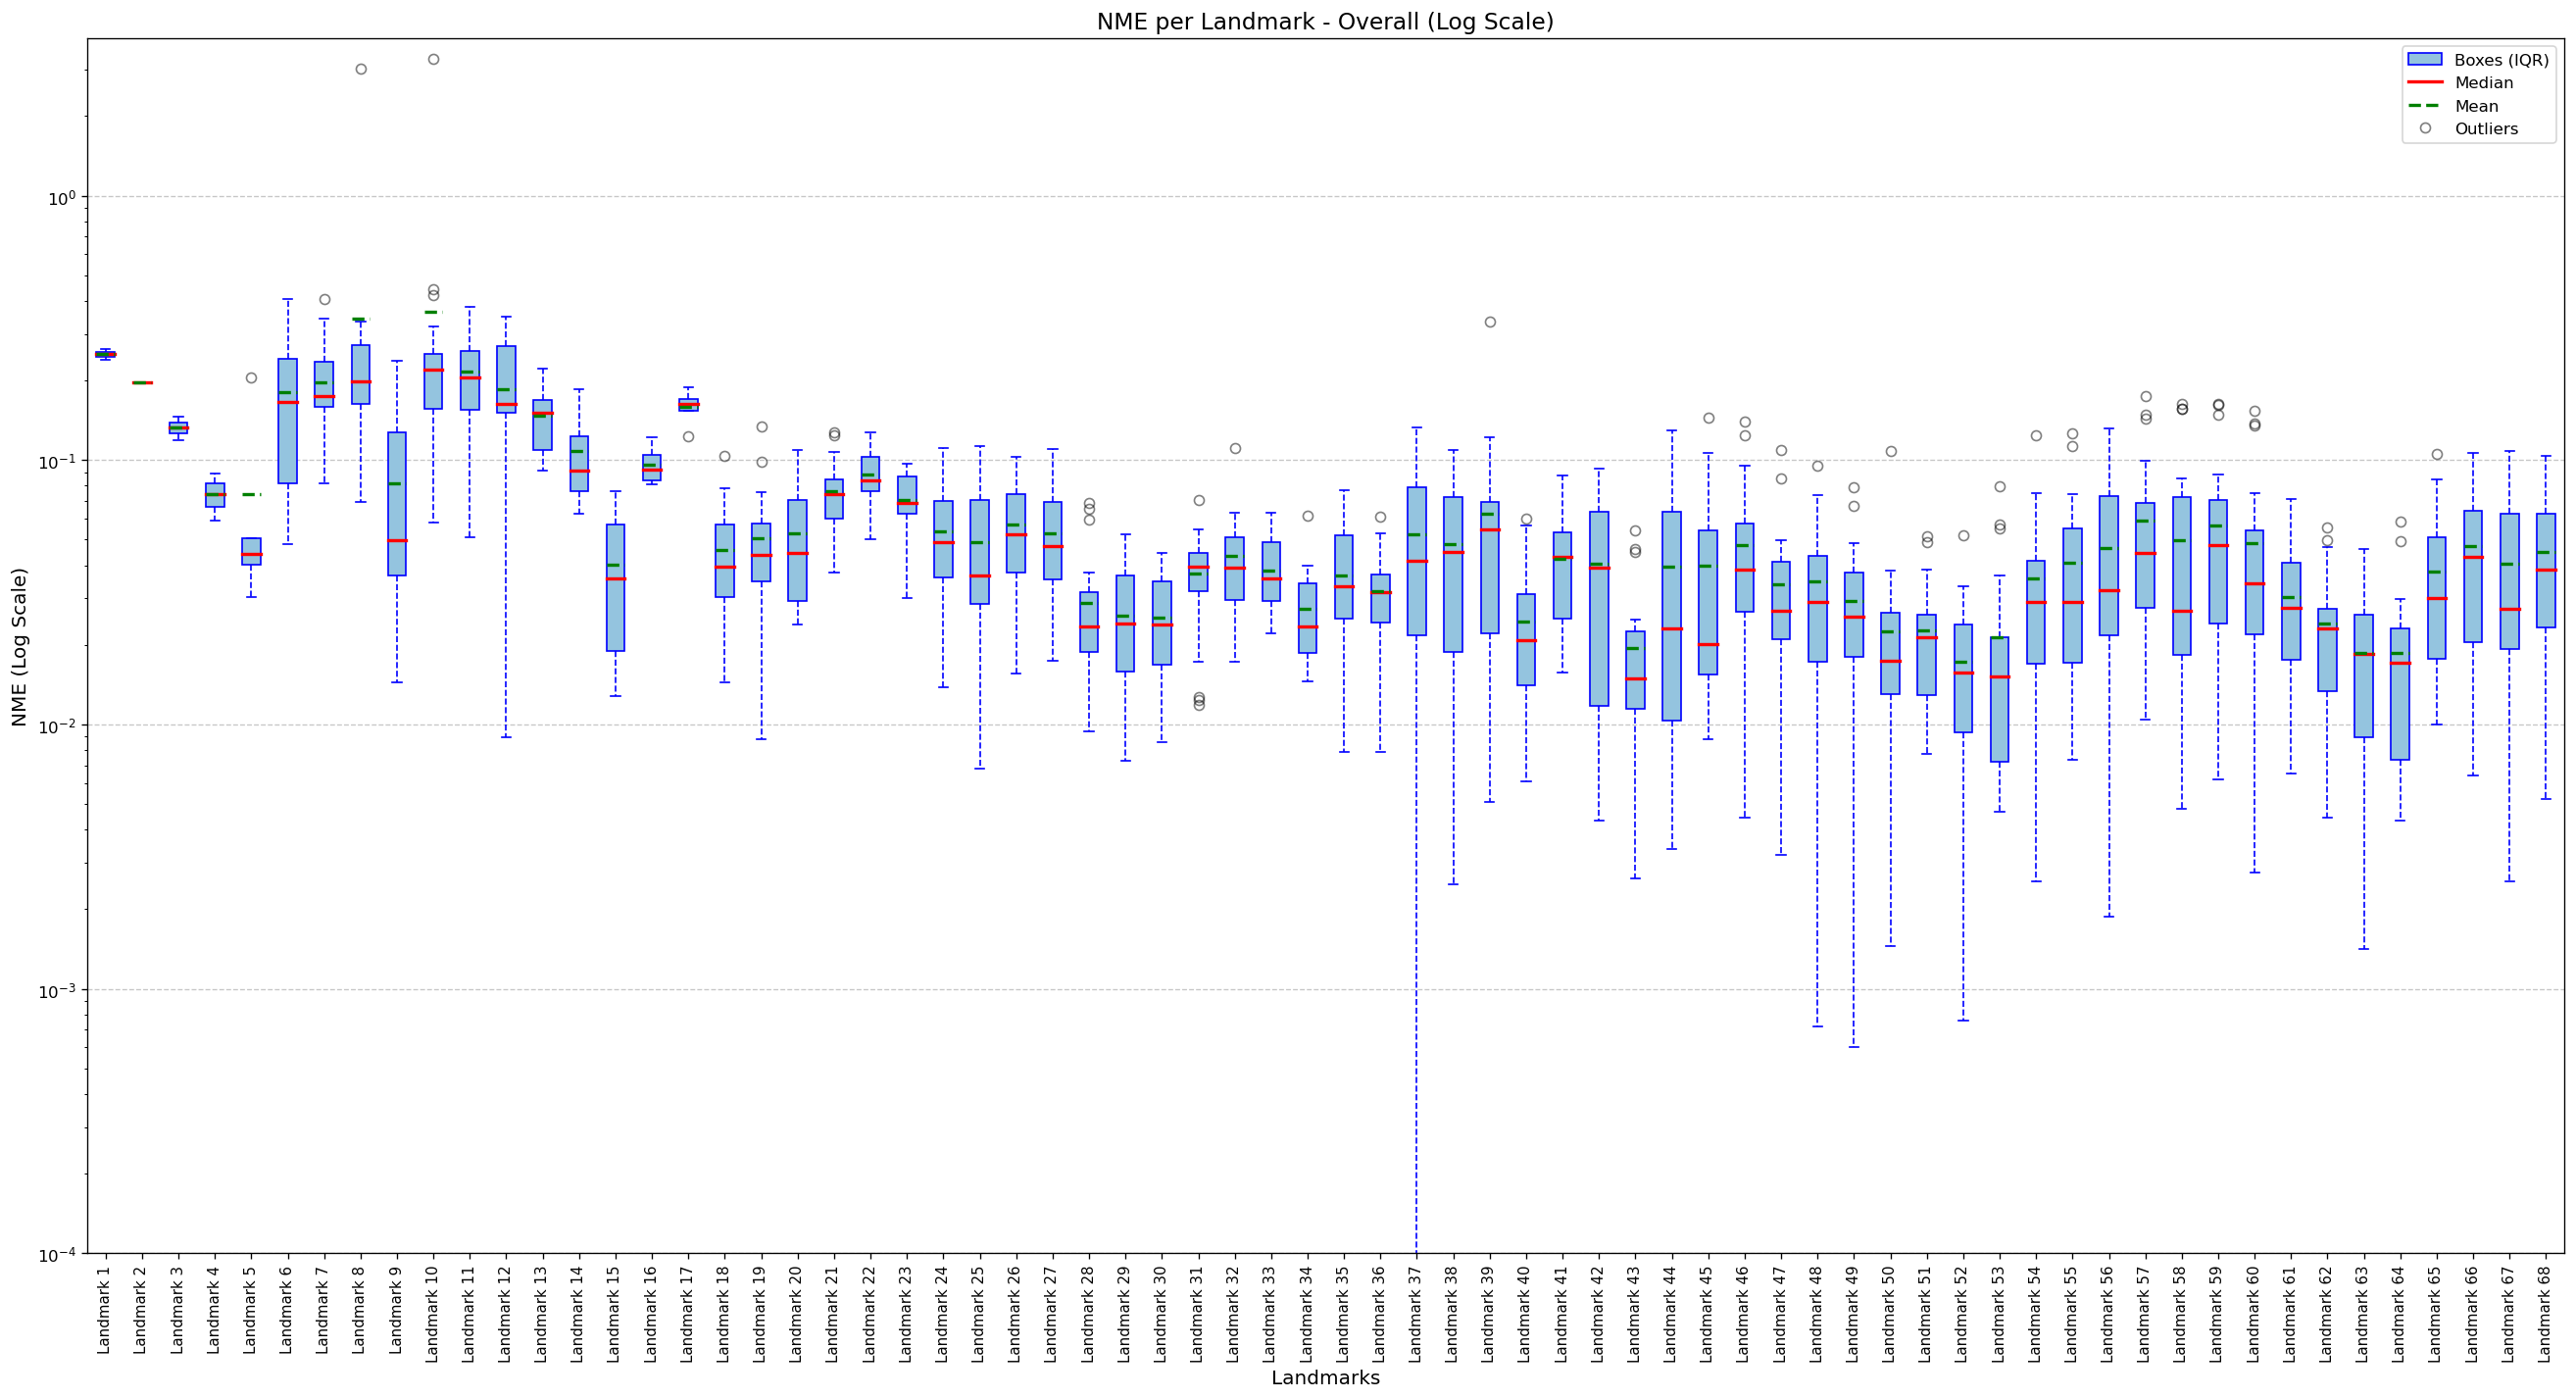

In [58]:
# Directorios de predicciones y ground truth
pred_dir = "/Users/jocareher/Downloads/dlib_predictions/labels"
gt_dir = "/Users/jocareher/Downloads/baby_face_72/labels"

# Lista de nombres de landmarks
landmark_names = [f"Landmark {i+1}" for i in range(68)]

# Evaluación del modelo
results = evaluate_model_performance(pred_dir, gt_dir)
# Mostrar resultados
print(f"Average NME (IOD): {results['average_nme_iod']}")
print(f"Average NME (BOX): {results['average_nme_box']}")
print(f"Detection Rate: {results['detection_rate']}%")
print(f"Skipped Files (Count): {results['skipped_count']}")
print(f"Skipped Files (List): {results['skipped_files']}")

# Generar boxplots
plot_nme_boxplots(pred_dir, gt_dir, landmark_names)


Average NME (IOD): 0.18576512647984528
Average NME (BOX): 0.15221967659935387
Detection Rate: 37.06896551724138%
Skipped Files (Count): 86
Skipped Files (List): ['face_bcn_00.txt', 'face_bcn_01.txt', 'face_bcn_04.txt', 'face_bcn_08.txt', 'face_bcn_09.txt', 'face_bcn_10.txt', 'face_bcn_103.txt', 'face_bcn_104.txt', 'face_bcn_11.txt', 'face_bcn_112.txt', 'face_bcn_113.txt', 'face_bcn_118.txt', 'face_bcn_119.txt', 'face_bcn_120.txt', 'face_bcn_121.txt', 'face_bcn_126.txt', 'face_bcn_127.txt', 'face_bcn_128.txt', 'face_bcn_129.txt', 'face_bcn_130.txt', 'face_bcn_131.txt', 'face_bcn_134.txt', 'face_bcn_135.txt', 'face_bcn_136.txt', 'face_bcn_14.txt', 'face_bcn_142.txt', 'face_bcn_143.txt', 'face_bcn_145.txt', 'face_bcn_146.txt', 'face_bcn_15.txt', 'face_bcn_155.txt', 'face_bcn_159.txt', 'face_bcn_160.txt', 'face_bcn_161.txt', 'face_bcn_162.txt', 'face_bcn_166.txt', 'face_bcn_167.txt', 'face_bcn_169.txt', 'face_bcn_17.txt', 'face_bcn_171.txt', 'face_bcn_173.txt', 'face_bcn_174.txt', 'face_bc

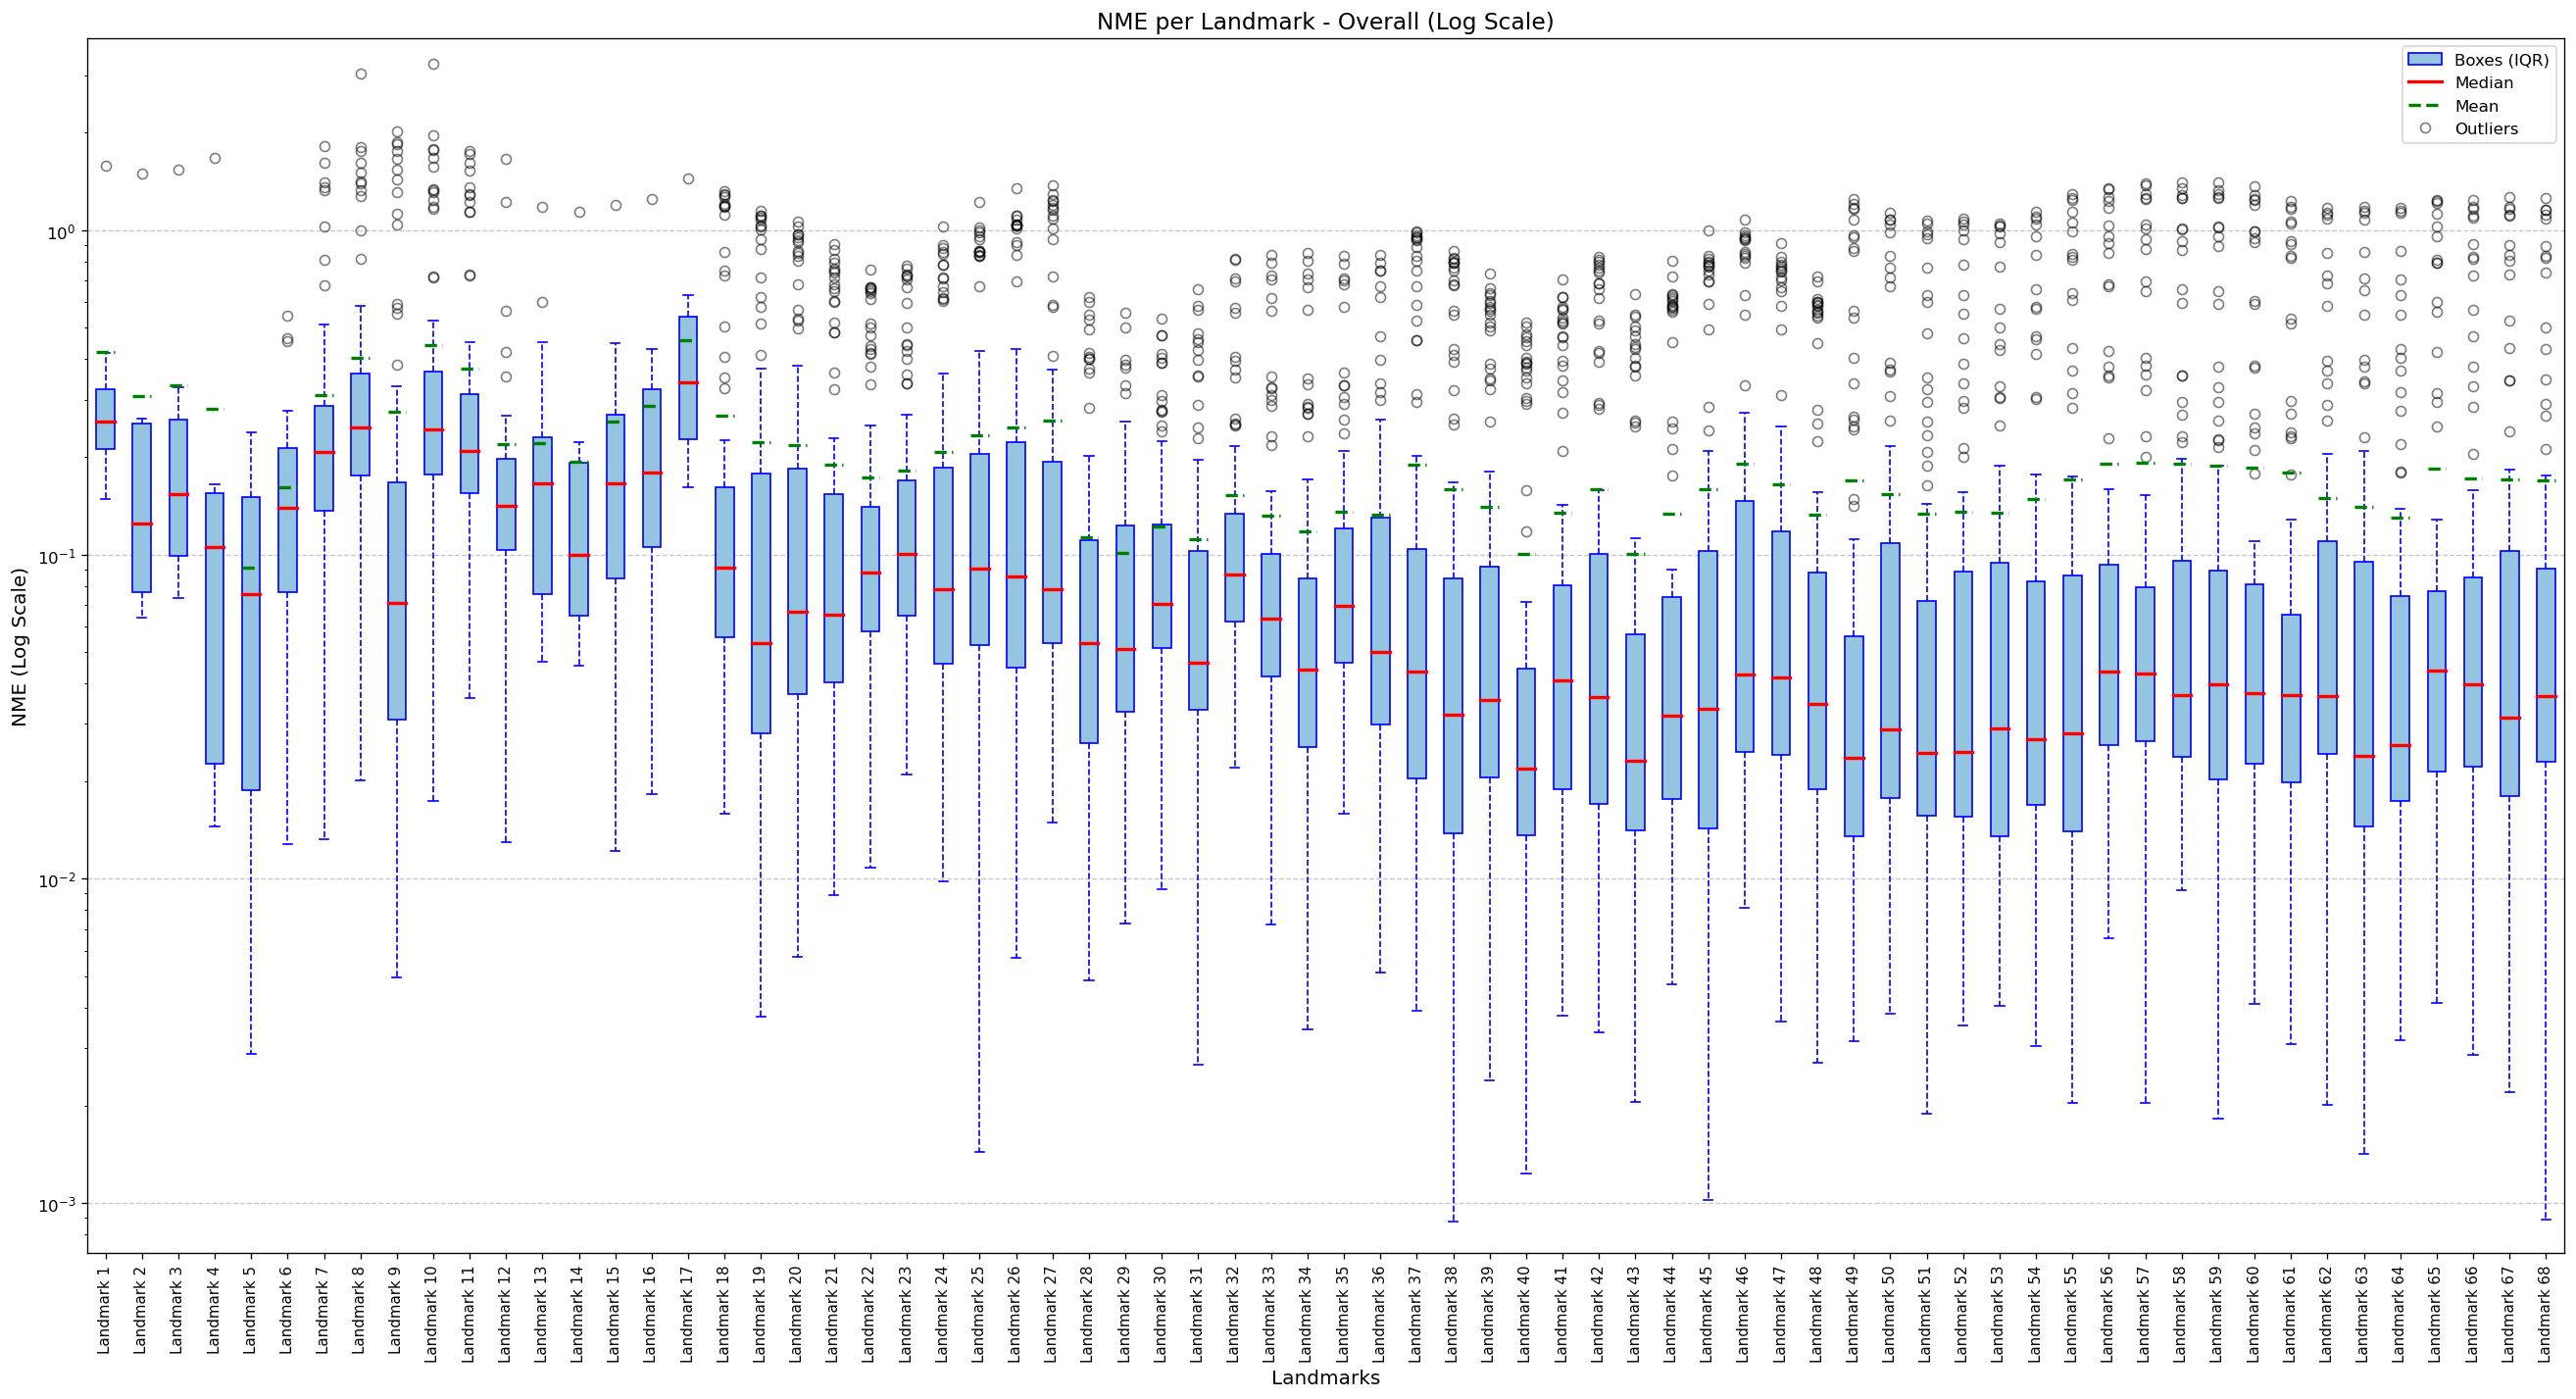

In [59]:
# Directorios de predicciones y ground truth
pred_dir = "/Users/jocareher/Downloads/mediapipe_68_lmks_predictions/labels"
gt_dir = "/Users/jocareher/Downloads/baby_face_72/labels"

# Lista de nombres de landmarks
landmark_names = [f"Landmark {i+1}" for i in range(68)]

# Evaluación del modelo
results = evaluate_model_performance(pred_dir, gt_dir)
# Mostrar resultados
print(f"Average NME (IOD): {results['average_nme_iod']}")
print(f"Average NME (BOX): {results['average_nme_box']}")
print(f"Detection Rate: {results['detection_rate']}%")
print(f"Skipped Files (Count): {results['skipped_count']}")
print(f"Skipped Files (List): {results['skipped_files']}")

# Generar boxplots
plot_nme_boxplots(pred_dir, gt_dir, landmark_names)

In [69]:
NUM_LANDMARKS = 72
EXPECTED_VALUES = NUM_LANDMARKS * 2  # 144

def create_landmark_mapping():
    """
    Crea el mapeo final ya validado de 72 landmarks.
    Aquí se asume que ya tienes un mapeo correcto.
    Si necesitas lógica adicional para extras, reintegrarla.
    """
    mapping = {
        0: 19, 1: 20, 2: 23, 3: 24, 4: 25, 5: 26, 6: 27, 7: 28, 8: 29, 9: 30,
        10: 31, 11: 32, 12: 33, 13: 34, 14: 35, 15: 22, 16: 21, 17: 36, 18: 37,
        19: 38, 20: 39, 21: 40, 22: 2, 23: 41, 24: 42, 25: 43, 26: 44, 27: 45,
        28: 0, 29: 48, 30: 49, 31: 1, 32: 3, 33: 52, 34: 53, 35: 4, 36: 51,
        37: 50, 38: 55, 39: 54, 40: 46, 41: 47, 42: 7, 43: 6, 44: 5, 45: 10,
        46: 9, 47: 8, 48: 11, 49: 56, 50: 12, 51: 13, 52: 14, 53: 57, 54: 15,
        55: 62, 56: 63, 57: 64, 58: 65, 59: 66, 60: 69, 61: 68, 62: 67, 63: 61,
        64: 60, 65: 16, 66: 59, 67: 58
    }

    # Ordenar por índice multipie
    final_map = [v for _, v in sorted(mapping.items(), key=lambda x: x[1])]
    if len(final_map) < 72:
        # Completar con duplicados si faltan
        while len(final_map) < 72:
            final_map.append(final_map[-1])
    elif len(final_map) > 72:
        final_map = final_map[:72]

    if len(final_map) != 72:
        raise ValueError("El mapa final no tiene 72 elementos.")

    return final_map

def load_groundtruth(file_path):
    """
    Carga los 72 landmarks del GT (144 valores). Si hay más de 144, se recorta, si menos, se descarta.
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        print(f"Warning: GT file {file_path} is empty or does not exist.")
        return None

    with open(file_path, 'r') as f:
        line = f.readline().strip()

    coords = line.split()
    if len(coords) != EXPECTED_VALUES:
        if len(coords) > EXPECTED_VALUES:
            print(f"Warning: Got {len(coords)} values, expected {EXPECTED_VALUES} in GT {file_path}. Taking only the first {EXPECTED_VALUES}.")
            coords = coords[:EXPECTED_VALUES]
        else:
            print(f"Error: Expected {EXPECTED_VALUES} values, got {len(coords)} in {file_path}")
            return None

    try:
        coords = list(map(float, coords))
    except ValueError as e:
        print(f"Error processing GT {file_path}: {e}")
        return None

    gt_landmarks = np.array(coords).reshape(NUM_LANDMARKS, 2)
    if gt_landmarks.shape != (72, 2):
        return None
    return gt_landmarks

def load_and_map_landmarks(file_path, mapping):
    """
    Carga predicciones:
    class_idx + 72*(x,y,vis) = 1 + 72*3 = 217 valores.
    Si hay más, se ignoran los extra, si hay menos, se descarta.
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        print(f"Warning: Prediction file {file_path} empty or not exist.")
        return None

    with open(file_path, 'r') as f:
        lines = f.readlines()

    if len(lines) == 0:
        return None

    first_line = lines[0].strip().split()
    if len(first_line) < 217:
        print(f"Error: Prediction file {file_path} doesn't have enough values. Expected at least 217, got {len(first_line)}.")
        return None

    # Si hay más de 217, solo tomamos lo necesario
    if len(first_line) > 217:
        print(f"Warning: Prediction file {file_path} has {len(first_line)} values, expected 217. Trimming extra.")
        first_line = first_line[:217]

    landmarks = []
    for i in range(NUM_LANDMARKS):
        x = float(first_line[1 + i*3])
        y = float(first_line[2 + i*3])
        landmarks.append((x, y))

    landmarks = np.array(landmarks)
    mapped_landmarks = landmarks[mapping]

    if mapped_landmarks.shape != (72, 2):
        print(f"Error: mapped landmarks shape {mapped_landmarks.shape} != (72,2)")
        return None

    return mapped_landmarks

def calculate_iod(landmarks):
    # Ajuste 0-based: MULTI-PIE #36→35, #45→44
    if len(landmarks) < 46:
        return np.nan
    left_eye = landmarks[35]
    right_eye = landmarks[44]
    if np.isnan(left_eye).any() or np.isnan(right_eye).any():
        return np.nan
    return np.linalg.norm(right_eye - left_eye)

def calculate_box(landmarks):
    valid_landmarks = landmarks[~np.isnan(landmarks).any(axis=1)]
    if len(valid_landmarks) == 0:
        return np.nan
    x_min, y_min = np.min(valid_landmarks, axis=0)
    x_max, y_max = np.max(valid_landmarks, axis=0)
    width = x_max - x_min
    height = y_max - y_min
    return np.sqrt(width * height)

def calculate_nme_per_face(pred_landmarks, gt_landmarks, normalization_factor):
    valid_indices = ~np.isnan(gt_landmarks).any(axis=1) & ~np.isnan(pred_landmarks).any(axis=1)
    if not valid_indices.any():
        return np.nan
    distances = np.linalg.norm(pred_landmarks[valid_indices] - gt_landmarks[valid_indices], axis=1)
    return np.mean(distances) / normalization_factor

def calculate_nme_with_mapping(pred_dir, gt_dir, mapping):
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch between predictions and groundtruth files."

    nme_iod_values = []
    nme_box_values = []
    skipped_files = []
    valid_detections = 0
    total_files = len(gt_files)

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        pred_landmarks = load_and_map_landmarks(pred_path, mapping)
        gt_landmarks = load_groundtruth(gt_path)

        # Razones de skip
        if pred_landmarks is None:
            print(f"Skipping {pred_file} - pred_landmarks is None or invalid.")
            skipped_files.append(pred_file)
            continue
        if gt_landmarks is None:
            print(f"Skipping {gt_file} - gt_landmarks is None or invalid.")
            skipped_files.append(pred_file)
            continue
        if pred_landmarks.shape != gt_landmarks.shape:
            print(f"Skipping {pred_file} - shape mismatch. Pred: {pred_landmarks.shape}, GT: {gt_landmarks.shape}")
            skipped_files.append(pred_file)
            continue

        iod = calculate_iod(gt_landmarks)
        box = calculate_box(gt_landmarks)
        if np.isnan(iod) or iod <= 0:
            print(f"Skipping {pred_file} - invalid IOD: {iod}")
            skipped_files.append(pred_file)
            continue
        if np.isnan(box) or box <= 0:
            print(f"Skipping {pred_file} - invalid BOX: {box}")
            skipped_files.append(pred_file)
            continue

        nme_iod = calculate_nme_per_face(pred_landmarks, gt_landmarks, iod)
        nme_box = calculate_nme_per_face(pred_landmarks, gt_landmarks, box)
        if not np.isnan(nme_iod):
            nme_iod_values.append(nme_iod)
        if not np.isnan(nme_box):
            nme_box_values.append(nme_box)

        valid_detections += 1

    detection_rate = (valid_detections / total_files * 100) if total_files > 0 else 0.0

    return {
        "average_nme_iod": np.mean(nme_iod_values) if nme_iod_values else None,
        "average_nme_box": np.mean(nme_box_values) if nme_box_values else None,
        "detection_rate": detection_rate,
        "skipped_files": skipped_files,
        "total_files": total_files,
        "valid_detections": valid_detections,
        "skipped_count": len(skipped_files)
    }

def plot_nme_boxplots(pred_dir, gt_dir, landmark_names, mapping):
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch in the number of prediction and ground truth files."

    nme_per_landmark = {i: [] for i in range(NUM_LANDMARKS)}

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        pred_landmarks = load_and_map_landmarks(pred_path, mapping)
        gt_landmarks = load_groundtruth(gt_path)

        if pred_landmarks is None or gt_landmarks is None:
            continue

        if pred_landmarks.shape != (72,2) or gt_landmarks.shape != (72,2):
            continue

        iod = calculate_iod(gt_landmarks)
        if np.isnan(iod) or iod <= 0:
            continue

        for i in range(NUM_LANDMARKS):
            if not (np.isnan(pred_landmarks[i]).any() or np.isnan(gt_landmarks[i]).any()):
                error = np.linalg.norm(pred_landmarks[i] - gt_landmarks[i]) / iod
                nme_per_landmark[i].append(error)

    nme_values = [nme_per_landmark[i] for i in range(NUM_LANDMARKS)]
    if all(len(vals) == 0 for vals in nme_values):
        print("No valid NME values to plot.")
        return

    all_nme_values = np.concatenate([vals for vals in nme_values if len(vals) > 0])
    y_min = max(all_nme_values.min() * 0.8, 1e-4)
    y_max = all_nme_values.max() * 1.2

    plt.figure(figsize=(22, 12), dpi=120)
    box = plt.boxplot(
        nme_values,
        showfliers=True,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
        medianprops=dict(color='red', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        whiskerprops=dict(color='blue', linestyle='--'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='purple', alpha=0.5),
    )

    plt.yscale('log')
    plt.ylim([y_min, y_max])
    plt.xticks(range(1, NUM_LANDMARKS+1), landmark_names, rotation=90, fontsize=9)
    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title("NME per Landmark - Overall (Log Scale)", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(
        [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
        ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
        loc='upper right',
        fontsize=10,
        frameon=True
    )
    plt.tight_layout()
    plt.show()


In [70]:
# Crear mapeo
mapping = create_landmark_mapping()

# Directorios
pred_dir_yolo = "/Users/jocareher/Downloads/model_fixed_bf72/labels"
gt_dir_yolo = "/Users/jocareher/Downloads/baby_face_72/labels"

# Calcular métricas
results = calculate_nme_with_mapping(pred_dir_yolo, gt_dir_yolo, mapping)

# Mostrar resultados
print(f"Average NME (IOD): {results['average_nme_iod']}")
print(f"Average NME (BOX): {results['average_nme_box']}")
print(f"Skipped Files: {results['skipped_files']}")
print(f"Skipped Files: {len(results['skipped_files'])}")


Skipping face_bcn_00.txt - pred_landmarks is None or invalid.
Skipping face_bcn_01.txt - pred_landmarks is None or invalid.
Skipping face_bcn_04.txt - pred_landmarks is None or invalid.
Skipping face_bcn_07.txt - pred_landmarks is None or invalid.
Skipping face_bcn_08.txt - pred_landmarks is None or invalid.
Skipping face_bcn_09.txt - pred_landmarks is None or invalid.
Skipping face_bcn_10.txt - pred_landmarks is None or invalid.
Skipping face_bcn_101.txt - pred_landmarks is None or invalid.
Skipping face_bcn_102.txt - pred_landmarks is None or invalid.
Skipping face_bcn_103.txt - invalid IOD: nan
Skipping face_bcn_104.txt - pred_landmarks is None or invalid.
Skipping face_bcn_105.txt - pred_landmarks is None or invalid.
Skipping face_bcn_106.txt - pred_landmarks is None or invalid.
Skipping face_bcn_107.txt - pred_landmarks is None or invalid.
Skipping face_bcn_109.txt - pred_landmarks is None or invalid.
Skipping face_bcn_11.txt - pred_landmarks is None or invalid.
Skipping face_bcn_

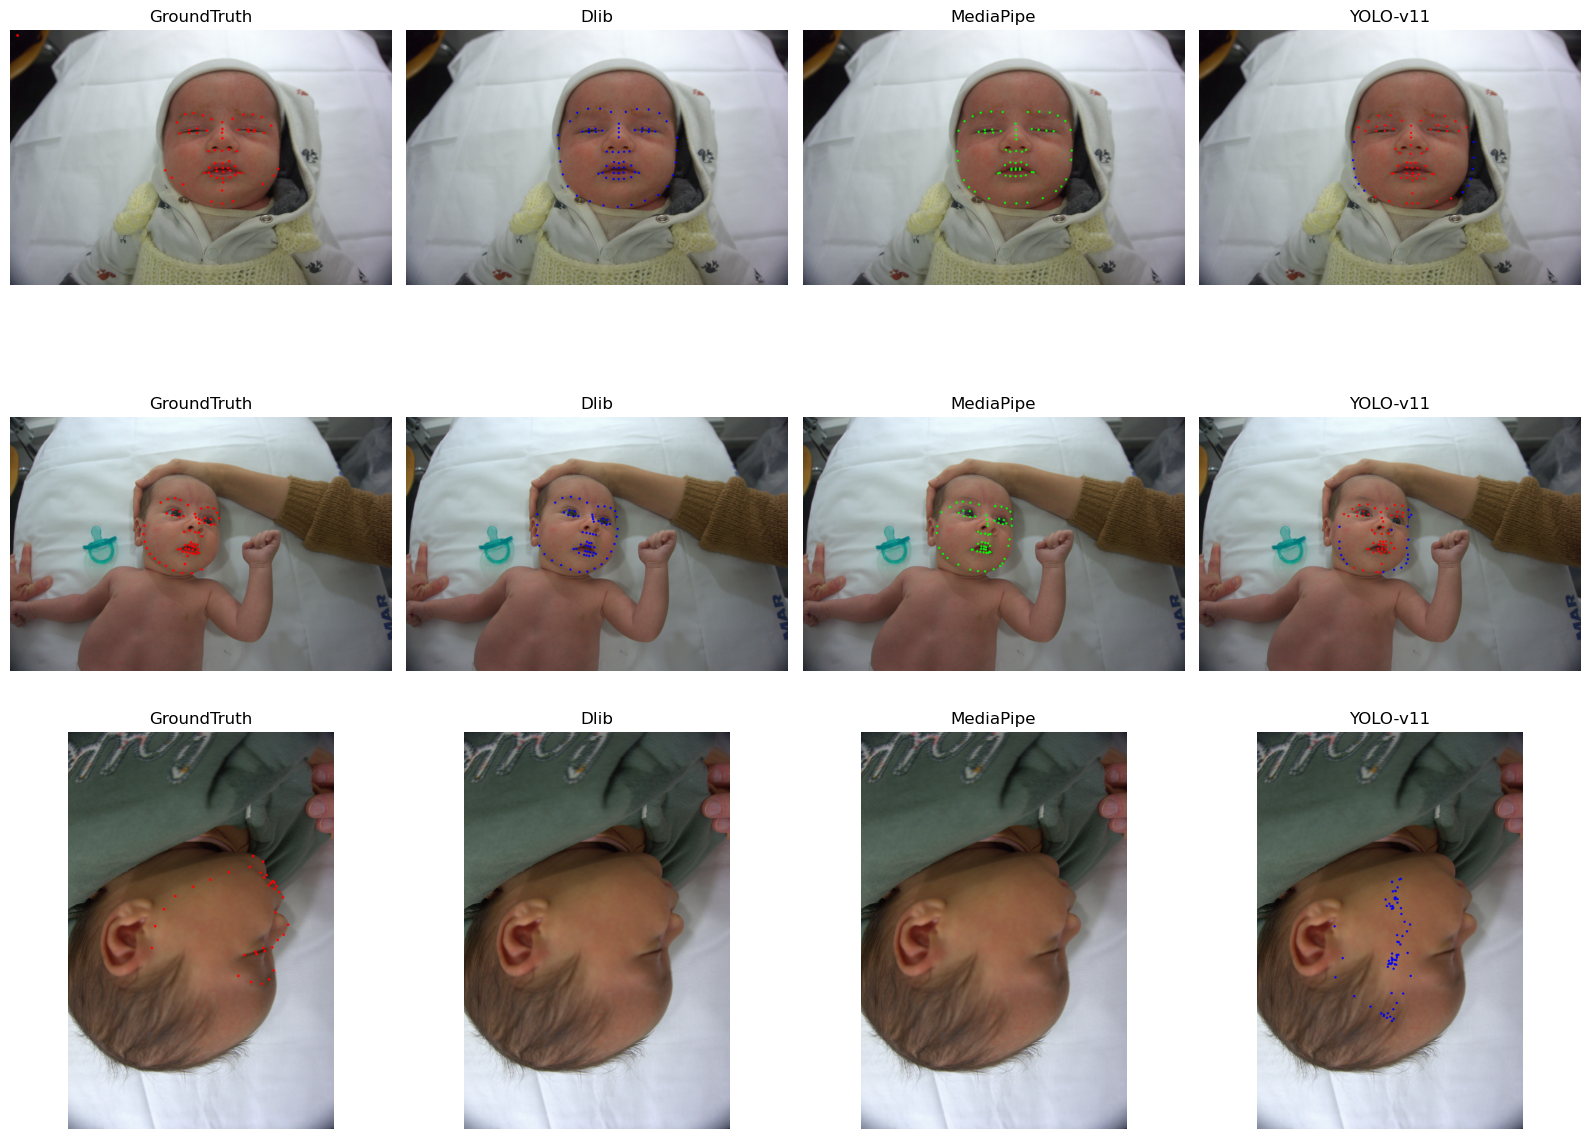

In [17]:
def create_comparison_grid(gt_dir, dlib_dir, mediapipe_dir, yolo_dir, output_path, grid_size=(3, 4)):
    """
    Creates a grid of images for visual comparison of landmarks from different models.
    
    Args:
        gt_dir (str): Directory containing ground truth images.
        dlib_dir (str): Directory containing Dlib predictions.
        mediapipe_dir (str): Directory containing MediaPipe predictions.
        yolo_dir (str): Directory containing YOLO-v11 predictions.
        output_path (str): Path to save the generated grid image.
        grid_size (tuple): Number of rows and columns in the grid (default: 3x4).

    Returns:
        None
    """
    # Filtrar archivos de imagen en minúsculas
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    dlib_files = sorted([f for f in os.listdir(dlib_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mediapipe_files = sorted([f for f in os.listdir(mediapipe_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    yolo_files = sorted([f for f in os.listdir(yolo_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Encontrar archivos comunes
    common_files = set(gt_files) & set(dlib_files) & set(mediapipe_files) & set(yolo_files)
    common_files = sorted(list(common_files))

    if not common_files:
        print("No common files found across the directories.")
        return

    # Mezclar y seleccionar un subconjunto aleatorio de archivos para el grid
    random.shuffle(common_files)
    # grid_size[0] = número de filas
    # grid_size[1] = número de columnas
    # Necesitamos filas * columnas archivos. Si hay menos archivos que la cantidad de subplots, tomamos lo que haya.
    num_needed = grid_size[0]
    files_to_display = common_files[:num_needed]

    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    # Por cada archivo en files_to_display, mostramos una fila completa de 4 imágenes (GT, Dlib, Mediapipe, YOLO)
    # Asegurar no superar el número de subplots
    for row_idx, file_name in enumerate(files_to_display):
        if row_idx * cols >= len(axs):
            break

        gt_path = os.path.join(gt_dir, file_name)
        dlib_path = os.path.join(dlib_dir, file_name)
        mediapipe_path = os.path.join(mediapipe_dir, file_name)
        yolo_path = os.path.join(yolo_dir, file_name)

        # Cargar imágenes con PIL
        images = [
            Image.open(gt_path),
            Image.open(dlib_path),
            Image.open(mediapipe_path),
            Image.open(yolo_path)
        ]
        titles = ["GroundTruth", "Dlib", "MediaPipe", "YOLO-v11"]

        # Mostrar las imágenes en la fila correspondiente
        for col_idx, (img, title) in enumerate(zip(images, titles)):
            ax_index = row_idx * cols + col_idx
            if ax_index >= len(axs):
                break
            ax = axs[ax_index]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(title)

    # Ocultar subplots no utilizados
    used_subplots = len(files_to_display) * cols
    for ax in axs[used_subplots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()




# Ejemplo de uso
gt_dir = "/Users/jocareher/Downloads/plots_babyface72"
dlib_dir = "/Users/jocareher/Downloads/dlib_predictions/images"
mediapipe_dir = "/Users/jocareher/Downloads/mediapipe_68_lmks_predictions/images"
yolo_dir = "/Users/jocareher/Downloads/model_fixed_bf72/images"
output_path = "comparison_grid.png"

# Generar una cuadrícula de 3 filas y 4 columnas
create_comparison_grid(gt_dir, dlib_dir, mediapipe_dir, yolo_dir, output_path, grid_size=(3, 4))


Total files: 232, Processed with data: 34, Skipped: 198
Landmark 1: 3 valores
Landmark 2: 3 valores
Landmark 3: 3 valores
Landmark 4: 3 valores
Landmark 5: 6 valores
Landmark 6: 12 valores
Landmark 7: 23 valores
Landmark 8: 26 valores
Landmark 9: 33 valores
Landmark 10: 34 valores
Landmark 11: 32 valores
Landmark 12: 23 valores
Landmark 13: 18 valores
Landmark 14: 16 valores
Landmark 15: 16 valores
Landmark 16: 16 valores
Landmark 17: 16 valores
Landmark 18: 21 valores
Landmark 19: 23 valores
Landmark 20: 24 valores
Landmark 21: 29 valores
Landmark 22: 31 valores
Landmark 23: 34 valores
Landmark 24: 33 valores
Landmark 25: 33 valores
Landmark 26: 34 valores
Landmark 27: 33 valores
Landmark 28: 33 valores
Landmark 29: 33 valores
Landmark 30: 34 valores
Landmark 31: 34 valores
Landmark 32: 24 valores
Landmark 33: 26 valores
Landmark 34: 34 valores
Landmark 35: 33 valores
Landmark 36: 34 valores
Landmark 37: 24 valores
Landmark 38: 25 valores
Landmark 39: 26 valores
Landmark 40: 25 valore

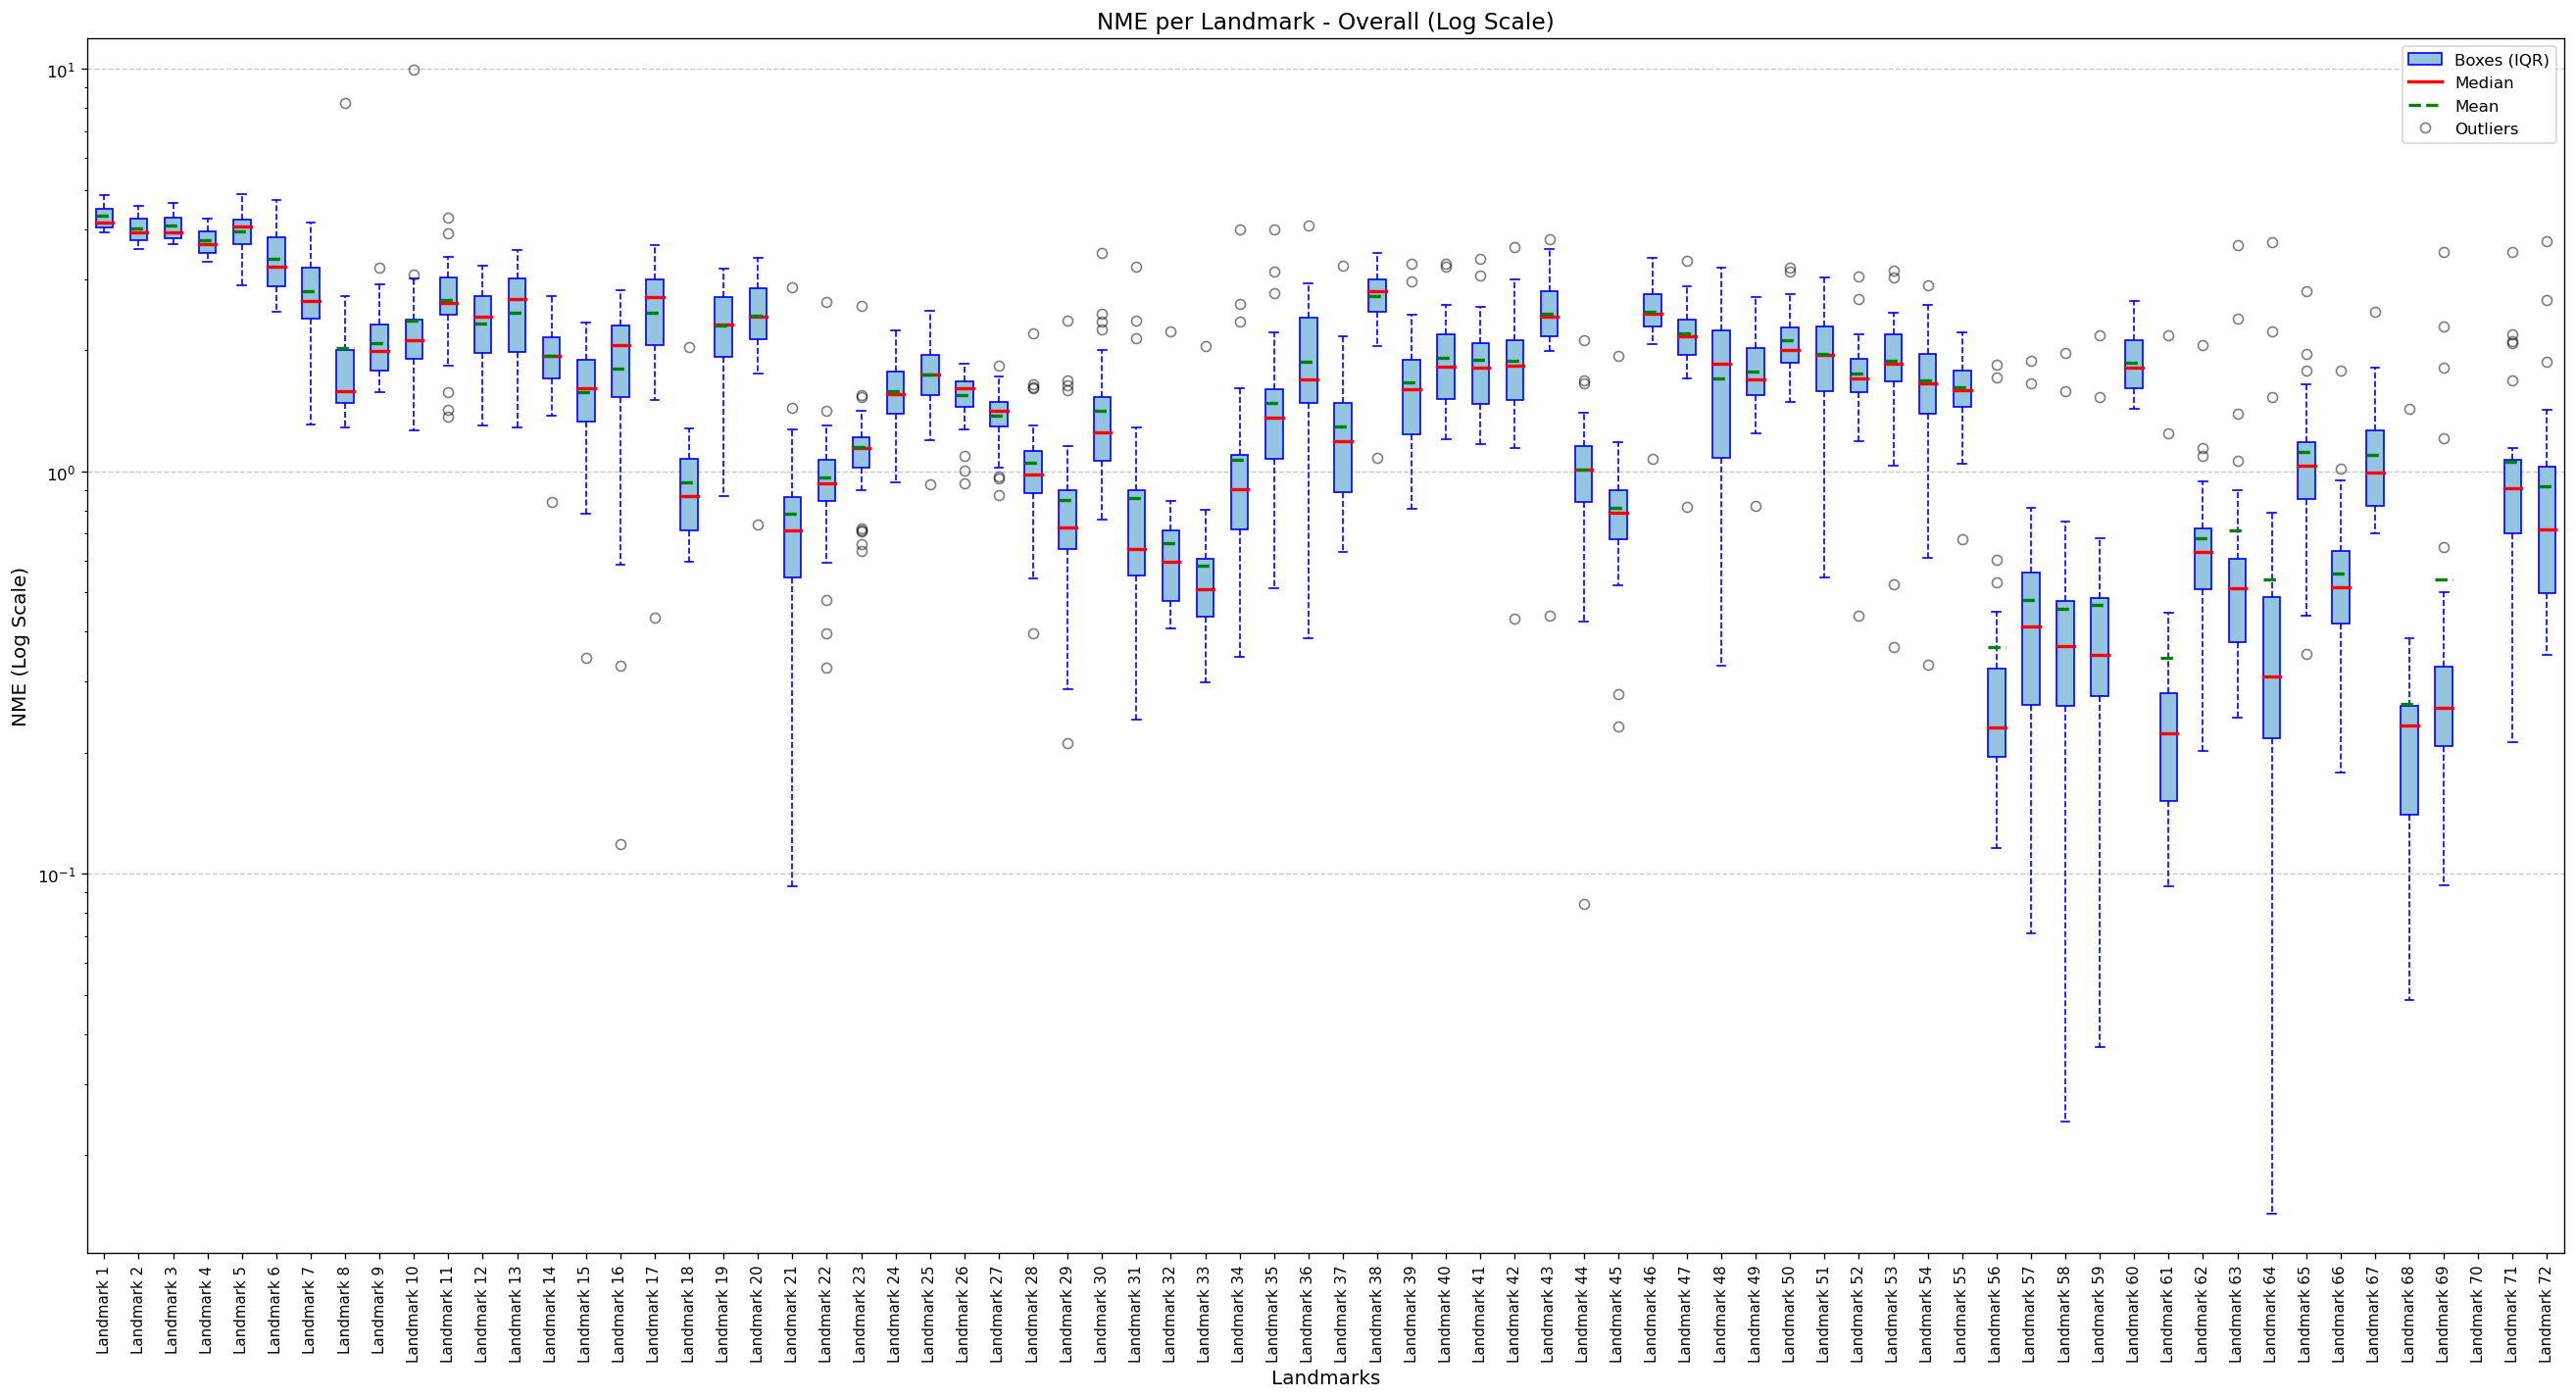

In [60]:
NUM_LANDMARKS = 72
EXPECTED_VALUES = NUM_LANDMARKS * 2  # 144 valores x,y

def load_groundtruth(file_path):
    """
    Carga los landmarks groundtruth desde un archivo .txt.
    Debe haber una sola línea con 144 valores (72 landmarks * 2 coords).
    Si hay más de 144, se recortan y se imprime un warning.
    Si hay menos, se descarta el archivo.
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        print(f"Warning: Groundtruth file {file_path} is empty or does not exist.")
        return None

    with open(file_path, 'r') as f:
        line = f.readline().strip()

    coords = line.split()
    if len(coords) != EXPECTED_VALUES:
        if len(coords) > EXPECTED_VALUES:
            print(f"Warning: Got {len(coords)} values, expected {EXPECTED_VALUES} in GT {file_path}. Taking only the first {EXPECTED_VALUES}.")
            coords = coords[:EXPECTED_VALUES]
        else:
            print(f"Error: Expected {EXPECTED_VALUES} values ({NUM_LANDMARKS} landmarks), but got {len(coords)} in file {file_path}.")
            return None

    # Convertir a float, nan se convertirá en np.nan automáticamente
    try:
        coords = list(map(float, coords))
    except ValueError as e:
        print(f"Error processing GT {file_path}: {e}")
        return None

    gt_landmarks = np.array(coords).reshape(NUM_LANDMARKS, 2)
    return gt_landmarks

def load_and_map_landmarks(file_path, mapping):
    """
    Carga las predicciones del modelo:
    - Primera línea: class_idx + 72*(x,y,visibility)
    - Segunda línea: Coordenadas de OBB (no se usan en este ejemplo).
    
    Se asume que la primera línea tiene 1 + 72*3 = 217 valores mínimo.
    Se aplicará el mapeo para reordenar los landmarks.
    """
    if not os.path.exists(file_path) or os.stat(file_path).st_size == 0:
        print(f"Warning: Prediction file {file_path} is empty or does not exist.")
        return None

    with open(file_path, 'r') as f:
        lines = f.readlines()

    if len(lines) == 0:
        return None

    first_line = lines[0].strip().split()

    # Se espera: 1 (class_idx) + (72*3) = 217 valores.
    if len(first_line) < 217:
        print(f"Error: Prediction file {file_path} doesn't have enough values. Expected at least 217, got {len(first_line)}.")
        return None

    landmarks = []
    # Omitimos el primer valor (class_idx), y luego tomamos x,y de cada tripleta
    for i in range(NUM_LANDMARKS):
        x = float(first_line[1 + i*3])
        y = float(first_line[2 + i*3])
        # visibility = float(first_line[3 + i*3]) # Si se necesita
        landmarks.append((x, y))

    landmarks = np.array(landmarks)
    mapped_landmarks = landmarks[mapping]

    if mapped_landmarks.shape != (NUM_LANDMARKS, 2):
        print(f"Error: mapped landmarks shape is {mapped_landmarks.shape}, expected (72,2)")
        return None

    return mapped_landmarks

def calculate_iod(landmarks):
    """
    Calcula la distancia interocular (IOD).
    Ajustar índices 0-based:
    Si usando MULTI-PIE estándar (landmark #36 y #45 en 1-based),
    en 0-based son landmarks[35] y landmarks[44].
    """
    if len(landmarks) < 46:
        return np.nan
    left_eye = landmarks[35]
    right_eye = landmarks[44]
    if np.isnan(left_eye).any() or np.isnan(right_eye).any():
        return np.nan
    return np.linalg.norm(right_eye - left_eye)

def calculate_box(landmarks):
    valid_landmarks = landmarks[~np.isnan(landmarks).any(axis=1)]
    if len(valid_landmarks) == 0:
        return np.nan
    x_min, y_min = np.min(valid_landmarks, axis=0)
    x_max, y_max = np.max(valid_landmarks, axis=0)
    width = x_max - x_min
    height = y_max - y_min
    return np.sqrt(width * height)

def calculate_nme_per_face(pred_landmarks, gt_landmarks, normalization_factor):
    valid_indices = ~np.isnan(gt_landmarks).any(axis=1) & ~np.isnan(pred_landmarks).any(axis=1)
    if not valid_indices.any():
        return np.nan
    distances = np.linalg.norm(pred_landmarks[valid_indices] - gt_landmarks[valid_indices], axis=1)
    return np.mean(distances) / normalization_factor

def plot_nme_boxplots(pred_dir, gt_dir, landmark_names, mapping):
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.txt')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.txt')])

    assert len(pred_files) == len(gt_files), "Mismatch in the number of prediction and ground truth files."

    nme_per_landmark = {i: [] for i in range(NUM_LANDMARKS)}

    total_files = len(pred_files)
    processed_files = 0
    skipped_files = 0

    for pred_file, gt_file in zip(pred_files, gt_files):
        pred_path = os.path.join(pred_dir, pred_file)
        gt_path = os.path.join(gt_dir, gt_file)

        pred_landmarks = load_and_map_landmarks(pred_path, mapping)
        gt_landmarks = load_groundtruth(gt_path)

        if pred_landmarks is None or gt_landmarks is None:
            skipped_files += 1
            continue

        if pred_landmarks.shape != gt_landmarks.shape:
            print(f"Skipping due to shape mismatch. Pred: {pred_landmarks.shape}, GT: {gt_landmarks.shape}")
            skipped_files += 1
            continue

        iod = calculate_iod(gt_landmarks)
        if isnan(iod) or iod <= 0:
            skipped_files += 1
            continue

        # Calcular NME por landmark
        valid_landmarks_count = 0
        for i in range(NUM_LANDMARKS):
            if np.isnan(pred_landmarks[i]).any() or np.isnan(gt_landmarks[i]).any():
                continue
            error = np.linalg.norm(pred_landmarks[i] - gt_landmarks[i]) / iod
            nme_per_landmark[i].append(error)
            valid_landmarks_count += 1

        if valid_landmarks_count > 0:
            processed_files += 1

    print(f"Total files: {total_files}, Processed with data: {processed_files}, Skipped: {skipped_files}")

    for i in range(NUM_LANDMARKS):
        print(f"Landmark {i+1}: {len(nme_per_landmark[i])} valores")

    # Convertir a formato para boxplot
    nme_values = [nme_per_landmark[i] for i in range(NUM_LANDMARKS)]

    all_values = [val for sublist in nme_values for val in sublist]
    if len(all_values) == 0:
        print("No data available to plot.")
        return

    all_nme_values = np.array(all_values)
    y_min = max(all_nme_values.min() * 0.8, 1e-4)
    y_max = all_nme_values.max() * 1.2

    plt.figure(figsize=(22, 12), dpi=120)
    box = plt.boxplot(
        nme_values,
        showfliers=True,
        showmeans=True,
        meanline=True,
        patch_artist=True,
        boxprops=dict(facecolor=cm.Blues(0.4), color='blue'),
        medianprops=dict(color='red', linewidth=2),
        meanprops=dict(color='green', linewidth=2),
        whiskerprops=dict(color='blue', linestyle='--'),
        capprops=dict(color='blue'),
        flierprops=dict(marker='o', color='purple', alpha=0.5),
    )

    plt.yscale('log')
    plt.ylim([y_min, y_max])

    plt.xticks(range(1, NUM_LANDMARKS+1), landmark_names, rotation=90, fontsize=9)
    plt.xlabel("Landmarks", fontsize=12)
    plt.ylabel("NME (Log Scale)", fontsize=12)
    plt.title("NME per Landmark - Overall (Log Scale)", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(
        [box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]],
        ['Boxes (IQR)', 'Median', 'Mean', 'Outliers'],
        loc='upper right',
        fontsize=10,
        frameon=True
    )

    plt.tight_layout()
    plt.show()


# Ejemplo de uso:
# Ajustar nombres de landmarks según corresponda (asumiendo 72)
landmark_names = [f"Landmark {i+1}" for i in range(NUM_LANDMARKS)]

# Supongamos que load_and_map_landmarks y mapping, así como pred_dir_yolo, gt_dir_yolo, están definidos
plot_nme_boxplots(pred_dir_yolo, gt_dir_yolo, landmark_names, mapping)